# **0.1 Imports**

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display       import Image
from matplotlib            import rcParams
import matplotlib.pyplot   as plt

import scipy.stats             as ss
from scipy.stats               import chi2_contingency 
import statsmodels.api         as sm
from category_encoders         import TargetEncoder
from fast_ml.model_development import train_valid_test_split
from sklearn.metrics           import mean_absolute_error, mean_squared_error,make_scorer, mean_absolute_percentage_error
from sklearn.model_selection   import cross_val_predict, KFold, cross_val_score
from sklearn.preprocessing     import RobustScaler,MinMaxScaler,LabelEncoder,StandardScaler
from sklearn.linear_model      import LinearRegression, Lasso
from sklearn.ensemble          import RandomForestRegressor
from xgboost                   import XGBRegressor
from catboost                  import CatBoostRegressor

## **0.1.1 Helper functions**

In [45]:
def mean_absolute_percentage_error_func(y, yhat):
    mask = y != 0
    return np.mean(np.abs(np.where(mask, (y - yhat) / y, 0)))

def mae_scorer(y_true, y_pred):
    return -mean_absolute_error(y_true, y_pred)  # Negativo porque cross_val_score espera escores mais altos

def mape_scorer(y_true, y_pred):
    return -np.mean(np.abs((y_true - y_pred) / y_true))

def mape_scorer(y_true, y_pred):
    mask = y_true != 0  # Cria uma máscara para evitar divisão por zero
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    if len(y_true_masked) == 0:
        # Caso não haja valores diferentes de zero, retorne 0 (ou outro valor apropriado)
        return 0.0

    return -np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked))

def rmse_scorer(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_cramers_v_matrix(dataframe):
    cols = dataframe.columns
    cramers_v_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

    for i in range(len(cols)):
        for j in range(len(cols)):
            if i == j:
                cramers_v_matrix.iloc[i, j] = 1.0
            else:
                cramers_v = calculate_cramers_v(dataframe[cols[i]], dataframe[cols[j]])
                cramers_v_matrix.iloc[i, j] = cramers_v
                cramers_v_matrix.iloc[j, i] = cramers_v

    return cramers_v_matrix

def calculate_cramers_v(var1, var2):
    contingency_table = pd.crosstab(var1, var2)
    
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def filter_mean(df,bairro_group,bairro,room_type):
    filter = (df['bairro_group'] == bairro_group) & (df['bairro'] == bairro) & (df['room_type'] == room_type)
    aux = df[filter]

    # Calculando a média de preço
    mean = aux['price'].mean()
    return round(mean)

## **0.1.2 Loading data**

In [46]:
df_raw=pd.read_csv('../datasets/raw.csv')

df_raw.head(5)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


# **1 Data description**

## **1.1 Dimensions**

In [47]:
df1=df_raw.copy()

In [48]:
print(f'Number of rows:{df1.shape[0]}')
print(f'Number of cols:{df1.shape[1]}')

Number of rows:48894
Number of cols:16


## **1.2 Data types**

In [49]:
df1.dtypes

id                                 int64
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object

### **1.2.2 Change types**

In [50]:
df1['ultima_review'] = pd.to_datetime(df1['ultima_review'])
df1['ultima_review'].dtype

dtype('<M8[ns]')

## **1.3 Check na**

In [51]:
df1.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

## **1.4 Fillout/delete na**

In [52]:
# ultima_review/reviews_por_mes
aux=df1[df1['numero_de_reviews']==0]

print(len(aux))

print(aux['ultima_review'].isna().sum())
print(aux['reviews_por_mes'].isna().sum())

aux['reviews_por_mes'].unique()

# se não há reviews, ultima_review e reviews_por_mes são vazios

10052
10052
10052


array([nan])

In [53]:
# substituir todos os NA de reviews_por_mes por 0

df1['reviews_por_mes'] = np.where(df1['reviews_por_mes'].isna(), 0, df1['reviews_por_mes'])
print(df1['reviews_por_mes'].isna().sum())
print(df1['reviews_por_mes'].min())

0
0.0


In [54]:
# ultima_review será mantida com os nans por hora, talvez seja possível excluir a variável futuramente

In [55]:
# substituir as linhas com nans em nome e host_name por 'desconhecido'

cols = ['nome','host_name']
df1[cols] = np.where(df1[cols].isna(), 'desconhecido', df1[cols])

print(df1['nome'].isna().sum())
print(df1['host_name'].isna().sum())

0
0


## **1.5 Descriptive statistics**

### **1.5.1 Numeric**

In [56]:
desc = df1.describe().T.reset_index()
desc.columns = ['attributes', 'count', 'mean', 'min', '25%', '50%', '75%', 'max', 'std']

desc

,attributes,count,mean,min,25%,50%,75%,max,std
0,id,48894.0,19017532.130609,2595.0,9472370.75,19677431.5,29152249.25,36487245.0,10982884.048876
1,host_id,48894.0,67621393.581605,2438.0,7822736.75,30795529.0,107434423.0,274321313.0,78611176.150486
2,latitude,48894.0,40.728951,40.49979,40.6901,40.723075,40.763117,40.91306,0.054529
3,longitude,48894.0,-73.952169,-74.24442,-73.98307,-73.95568,-73.936273,-73.71299,0.046157
4,price,48894.0,152.720763,0.0,69.0,106.0,175.0,10000.0,240.156625
5,minimo_noites,48894.0,7.030085,1.0,1.0,3.0,5.0,1250.0,20.510741
6,numero_de_reviews,48894.0,23.274758,0.0,1.0,5.0,24.0,629.0,44.550991
7,ultima_review,38842,2018-10-04 01:46:50.710055936,2011-03-28 00:00:00,2018-07-08 00:00:00,2019-05-19 00:00:00,2019-06-23 00:00:00,2019-07-08 00:00:00,NaN
8,reviews_por_mes,48894.0,1.090928,0.0,0.04,0.37,1.58,58.5,1.597294
9,calculado_host_listings_count,48894.0,7.144005,1.0,1.0,1.0,2.0,327.0,32.952855


### **1.5.2 Categorical**

In [57]:
colunas = ['nome', 'host_name', 'bairro_group', 'bairro', 'room_type']

for coluna in colunas:
    print(f"{coluna.capitalize()}s únicos: {len(df1[coluna].unique())}")

Nomes únicos: 47905
Host_names únicos: 11453
Bairro_groups únicos: 5
Bairros únicos: 221
Room_types únicos: 3


# **<s>2 Feature engineering</s>**

In [58]:
df2=df1.copy()

## **Train, validation, test separation**

In [59]:
x_train, y_train, x_val, y_val, x_test, y_test = train_valid_test_split(df2, 
                                                        target = 'price', 
                                                        train_size=0.8, valid_size=0.1, test_size=0.1,
                                                        random_state=42)

df2=pd.concat ([x_train, y_train], axis=1).reset_index(drop=True) 

print(len(df2))
print(len(x_train))
print(len(x_val))
print(len(x_test))
print(len(y_train))
print(len(y_val))
print(len(y_test))

39115
39115
4889
4890
39115
4889
4890


# **3 Variable filtering**<s/>

In [60]:
df3=df2.copy()

In [61]:
df3[df3['price']==0]

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,price
3449,21291569,Coliving in Brooklyn! Modern design / Shared room,101970559,Sergii,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,30,2,2019-06-22,0.11,6,333,0
5423,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,5,3,2018-01-02,0.15,1,73,0
6263,20639914,Cozy yet spacious private brownstone bedroom,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,1,95,2019-06-23,4.35,6,222,0
15934,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,2,55,2019-06-24,2.56,4,127,0
16030,20639792,Contemporary bedroom in brownstone with nice view,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,1,95,2019-06-21,4.37,6,232,0
17115,20639628,Spacious comfortable master bedroom with nice ...,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,1,93,2019-06-15,4.28,6,176,0
17147,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,4,1,2018-01-06,0.05,4,28,0
31707,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,2,12,2017-10-27,0.53,2,0,0
38671,20933849,the best you can find,13709292,Qiuchi,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,3,0,NaT,0.00,1,0,0


In [62]:
# substituir os preços igual a zero pela média baseada nas principais características

mean1=filter_mean(df3,'Brooklyn','Bushwick','Shared room')
mean2=filter_mean(df3,'Brooklyn','Williamsburg','Entire home/apt')
mean3=filter_mean(df3,'Brooklyn','Bedford-Stuyvesant','Private room')
mean4=filter_mean(df3,'Bronx','East Morrisania','Private room')
mean5=filter_mean(df3,'Brooklyn','Bedford-Stuyvesant','Private room')
mean6=filter_mean(df3,'Brooklyn','Greenpoint','Private room')
mean7=filter_mean(df3,'Manhattan','Murray Hill','Entire home/apt')

df3['price'] = np.where(df3['id'] == 21291569, mean1, df3['price'])
df3['price'] = np.where(df3['id'] == 20624541, mean2, df3['price'])
df3['price'] = np.where(df3['id'] == 20639914, mean3, df3['price'])
df3['price'] = np.where(df3['id'] == 20333471, mean4, df3['price'])
df3['price'] = np.where(df3['id'] == 20639792, mean5, df3['price'])
df3['price'] = np.where(df3['id'] == 20639628, mean5, df3['price'])
df3['price'] = np.where(df3['id'] == 18750597, mean5, df3['price'])
df3['price'] = np.where(df3['id'] == 20608117, mean6, df3['price'])
df3['price'] = np.where(df3['id'] == 20933849, mean7, df3['price'])

# **4 Exploratory data analysis**

In [63]:
df4=df3.copy()

## **4.1 Univariate analysis**

### **4.1.1 Response variable**

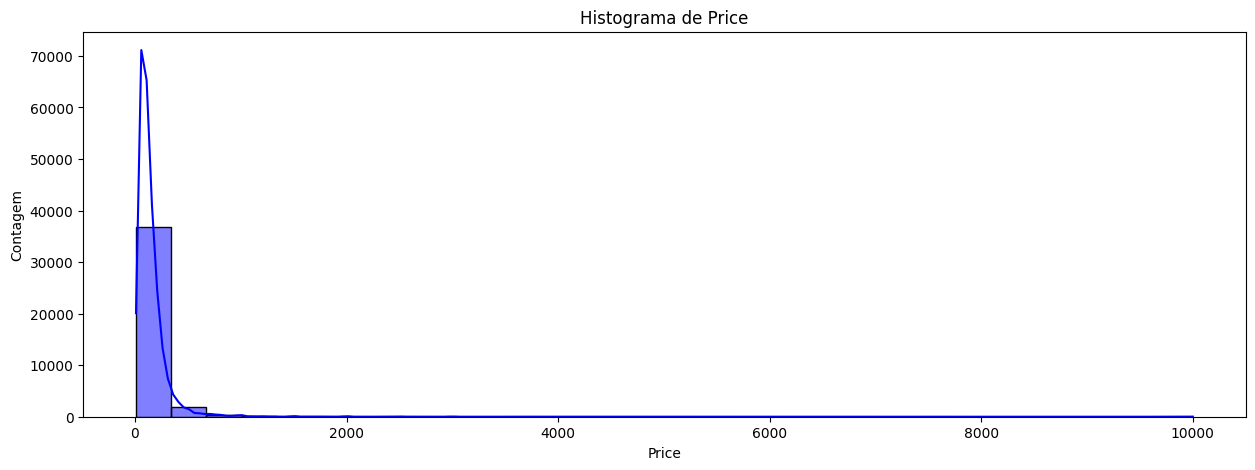

In [42]:
plt.figure(figsize=(15, 5)) 
sns.histplot(df4['price'], bins=30, kde=True, color='blue')
plt.title('Histograma de Price')
plt.xlabel('Price')
plt.ylabel('Contagem')
plt.show()

In [43]:
print(len(df4[df4['price']==0]))
print('\n')
df4[df4['price']==0]

0




,id,nome,host_id,host_name,bairro_group,...,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,price


### **4.1.2 Numerical variables**

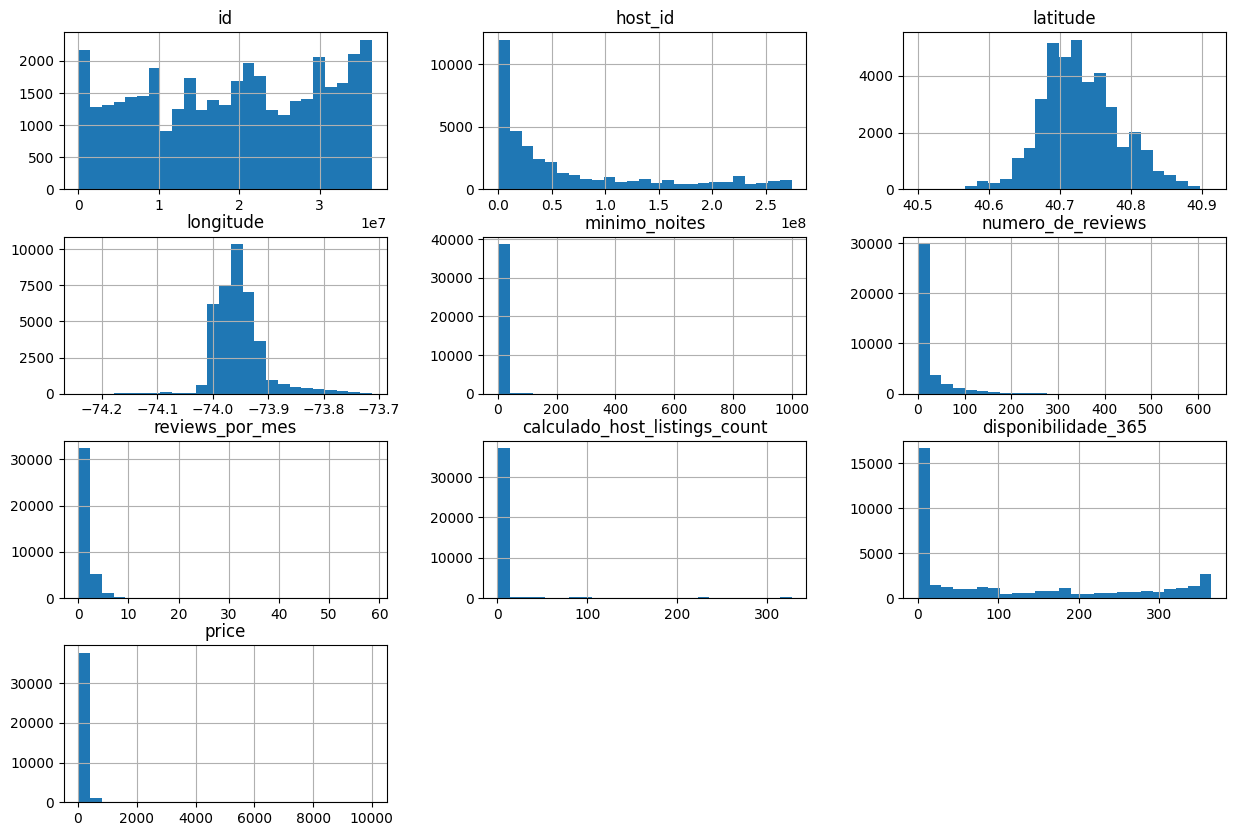

In [44]:
rcParams['figure.figsize'] = 15,10

num_attributes = df4.select_dtypes(include=['int64', 'float64'])
num_attributes.hist(bins=25);

### **4.1.3 Categorical variables**

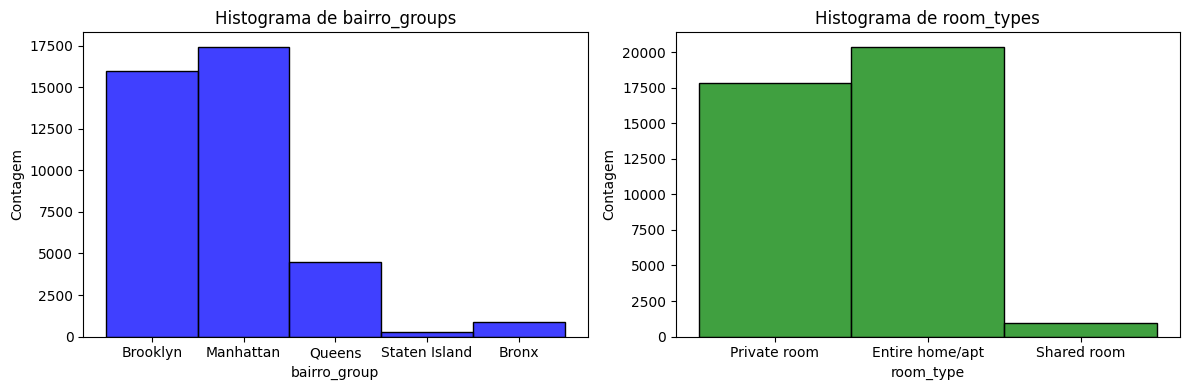

In [45]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(df4['bairro_group'], color='blue', bins=len(df4['bairro_group'].unique()))
plt.title('Histograma de bairro_groups')
plt.xlabel('bairro_group')
plt.ylabel('Contagem')

plt.subplot(1, 2, 2)
sns.histplot(df4['room_type'], color='green', bins=len(df4['room_type'].unique()))
plt.title('Histograma de room_types')
plt.xlabel('room_type')
plt.ylabel('Contagem')

plt.tight_layout()
plt.show()

In [46]:
df4['bairro'].value_counts().head(20)

bairro
Williamsburg          3118
Bedford-Stuyvesant    2974
Harlem                2144
Bushwick              1945
Upper West Side       1592
Hell's Kitchen        1577
East Village          1504
Upper East Side       1442
Midtown               1259
Crown Heights         1250
Greenpoint             906
East Harlem            899
Chelsea                897
Astoria                728
Lower East Side        719
Washington Heights     710
West Village           614
Financial District     595
Flatbush               495
Clinton Hill           443
Name: count, dtype: int64

## **4.2 Hypothesis**

### **4.2.1 Hypothesis mindmap**

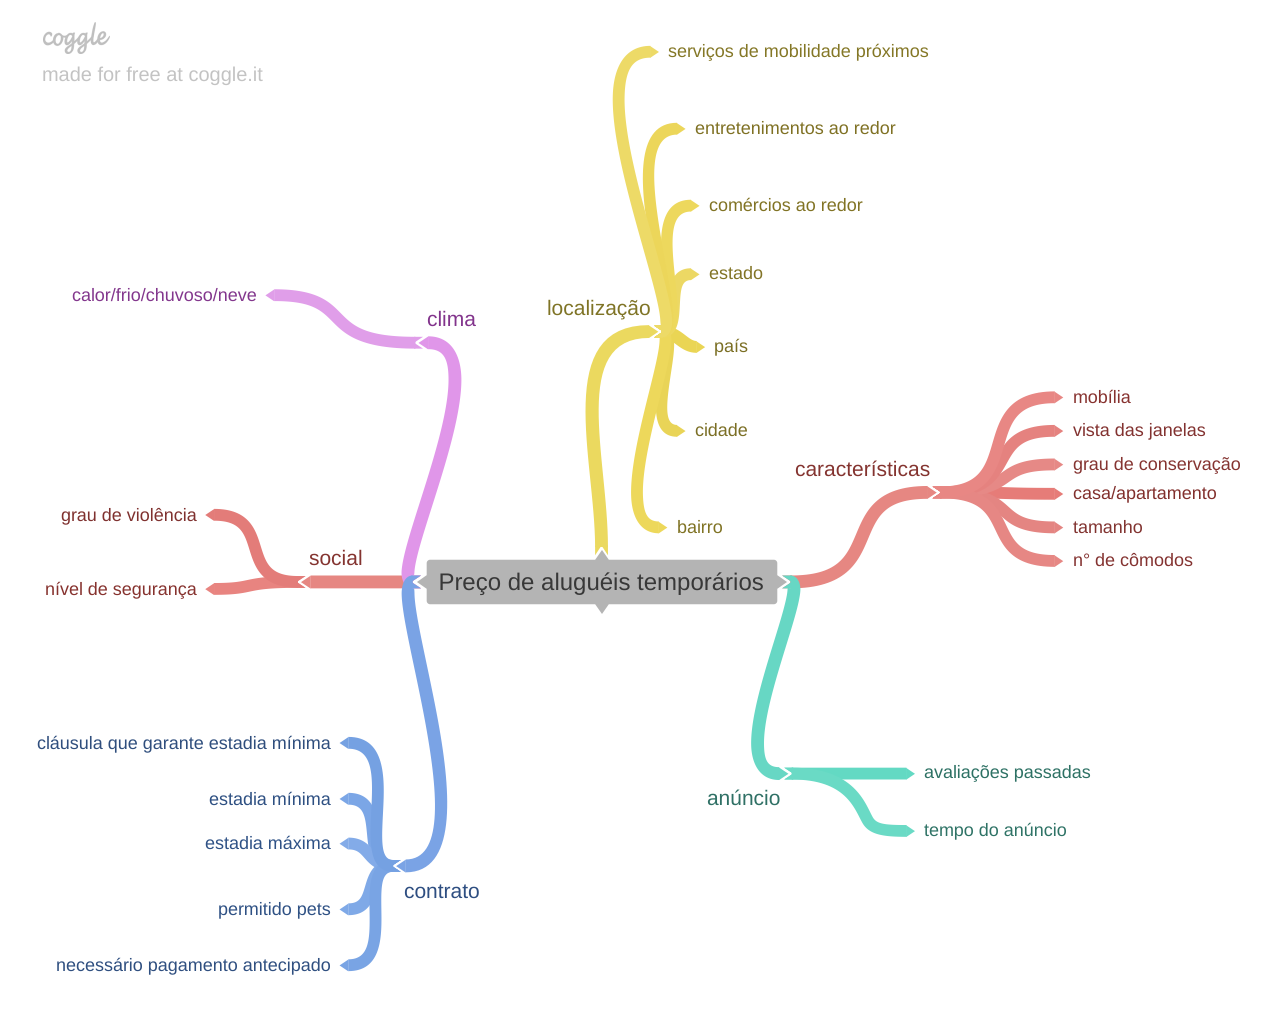

In [47]:
Image('../img/mindmap.png')

### **4.2.2 Hypothesis creation**

#### **H1 - Manhattan tem em média preços pelo menos 30% maiores**
**True**



A diferença percentual da média de Manhattan em relação às outras cidades:

    bairro_group  diff_percent
0      Manhattan      0.000000
1       Brooklyn    -36.945324
2  Staten Island    -41.158341
3         Queens    -49.250131
4          Bronx    -55.832950


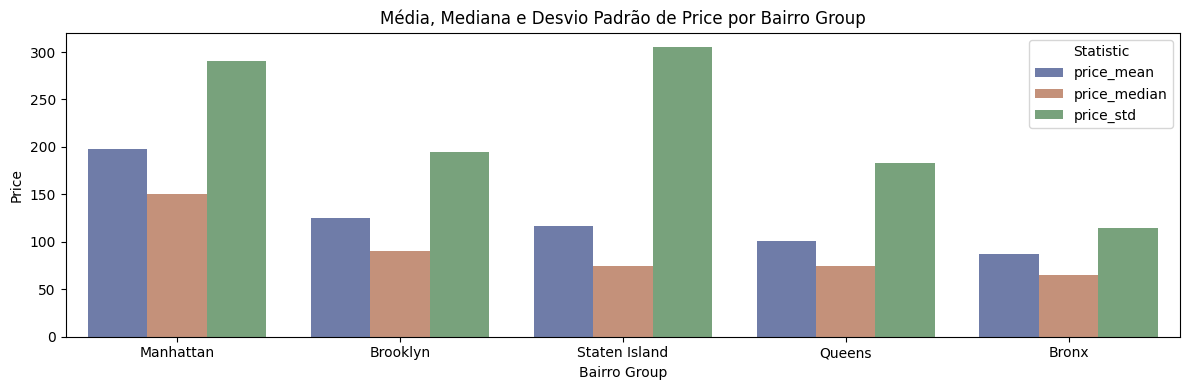

In [48]:
aux1 = df4[['bairro_group', 'price']].groupby('bairro_group').mean().sort_values('price', ascending=False).reset_index()
aux2 = df4[['bairro_group', 'price']].groupby('bairro_group').median().sort_values('price', ascending=False).reset_index()
aux3 = df4[['bairro_group', 'price']].groupby('bairro_group').std().sort_values('price', ascending=False).reset_index()

result1 = pd.merge(aux1, aux2, on='bairro_group', suffixes=('_mean', '_median'))
result2 = pd.merge(result1, aux3, on='bairro_group', suffixes=('', '_std'))
aux = result2.rename(columns={'price': 'price_std'})

viz = pd.melt(aux, id_vars=['bairro_group'], value_vars=['price_mean', 'price_median', 'price_std'],
              var_name='Statistic', value_name='Value')

plt.figure(figsize=(12, 4))
ax = sns.barplot(
    data=viz, x="bairro_group", y="Value", hue="Statistic",
    errorbar="sd", palette="dark", alpha=.6)

ax.set_title('Média, Mediana e Desvio Padrão de Price por Bairro Group')
ax.set_xlabel('Bairro Group')
ax.set_ylabel('Price')

plt.tight_layout()

city = 'Manhattan'
manhattan_mean = aux.loc[aux['bairro_group'] == city, 'price_mean'].values[0]
aux['diff_percent'] = ((aux['price_mean'] - manhattan_mean) / manhattan_mean) * 100

print('\n')
print(f"A diferença percentual da média de {city} em relação às outras cidades:\n")
print(aux[['bairro_group', 'diff_percent']])

#### **H2 - Room type do tipo 'Entire home/apt' são pelo menos 100% mais caros em média**
**False**



A diferença percentual da média de Entire home/apt em relação aos outros room types:

         room_type  diff_percent
0  Entire home/apt      0.000000
1     Private room    -57.714187
2      Shared room    -67.184348


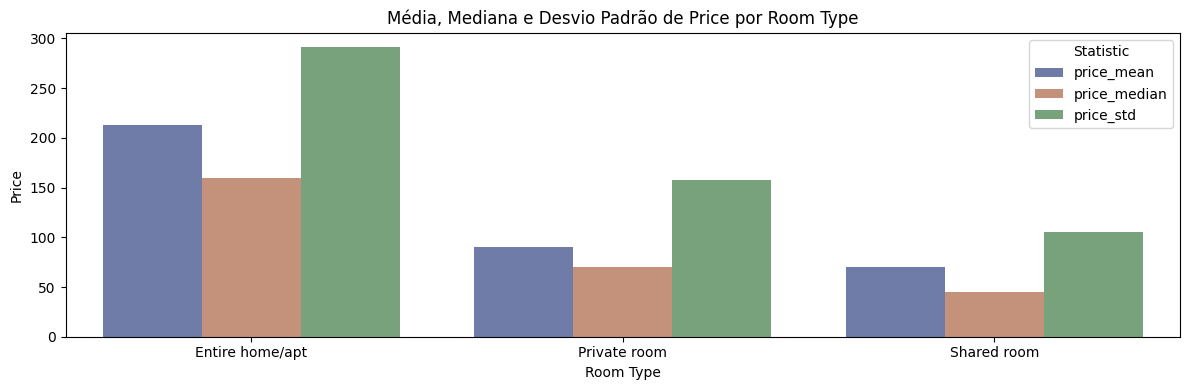

In [49]:
aux1 = df4[['room_type', 'price']].groupby('room_type').mean().sort_values('price', ascending=False).reset_index()
aux2 = df4[['room_type', 'price']].groupby('room_type').median().sort_values('price', ascending=False).reset_index()
aux3 = df4[['room_type', 'price']].groupby('room_type').std().sort_values('price', ascending=False).reset_index()

result1 = pd.merge(aux1, aux2, on='room_type', suffixes=('_mean', '_median'))
result2 = pd.merge(result1, aux3, on='room_type', suffixes=('', '_std'))
aux = result2.rename(columns={'price': 'price_std'})

viz = pd.melt(aux, id_vars=['room_type'], value_vars=['price_mean', 'price_median', 'price_std'],
              var_name='Statistic', value_name='Value')

plt.figure(figsize=(12, 4))
sns.barplot(
    data=viz, x="room_type", y="Value", hue="Statistic",
    errorbar="sd", palette="dark", alpha=.6)

plt.title('Média, Mediana e Desvio Padrão de Price por Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.legend(title='Statistic')

plt.tight_layout()

room = 'Entire home/apt'
room_mean = aux.loc[aux['room_type'] == room, 'price_mean'].values[0]
aux['diff_percent'] = ((aux['price_mean'] - room_mean) / room_mean) * 100

print('\n')
print(f"A diferença percentual da média de {room} em relação aos outros room types:\n")
print(aux[['room_type', 'diff_percent']])

#### **H3 Aluguéis disponíveis por no máximo uma semana são pelo menos 30% mais caros em média**

In [50]:
aux=df4[['minimo_noites','price']].groupby('minimo_noites').mean().sort_values('price',ascending=False).reset_index()

# check outliers
aux.sort_values('price',ascending=False).head(10)

,minimo_noites,price
0,114,4200.000000
1,100,1141.500000
2,40,464.833333
3,1000,400.000000
4,70,395.750000
5,365,388.434783
6,175,350.000000
7,198,346.000000
8,23,320.000000
9,80,269.285714




A média do preço para minimo_noites até 7 é: 154.79
A média do preço para minimo_noites maior que 7 é: 147.16
A diferença percentual é: -5.18%


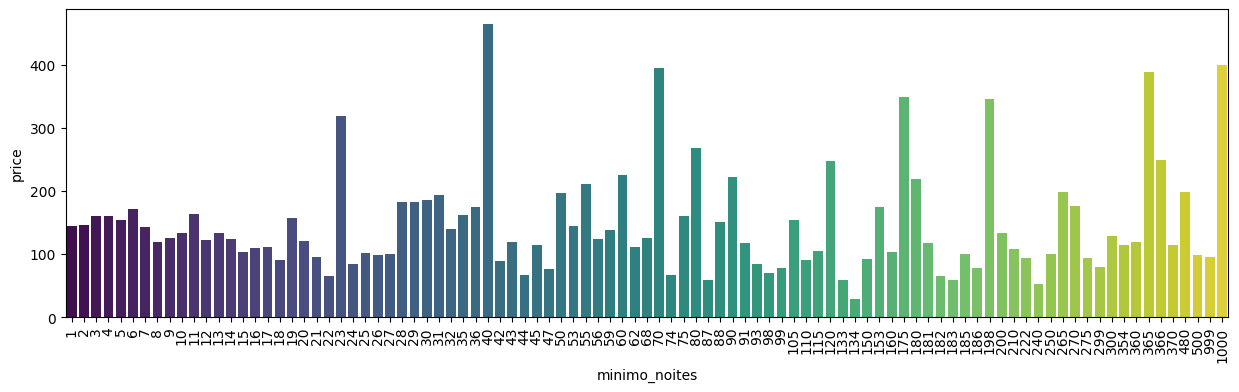

In [51]:
aux=aux[aux['price']<1000]

plt.figure(figsize=(15, 4))
sns.barplot(data=aux, x='minimo_noites', y='price', ci='sd', palette='viridis')
plt.xticks(rotation=90)

condicao = aux['minimo_noites'] <= 7

media_menor_7 = aux.loc[condicao, 'price'].mean()
media_maior_7 = aux.loc[~condicao, 'price'].mean()

diff_percent = ((media_maior_7 - media_menor_7) / media_maior_7) * 100

print('\n')
print(f"A média do preço para minimo_noites até 7 é: {media_menor_7:.2f}")
print(f"A média do preço para minimo_noites maior que 7 é: {media_maior_7:.2f}")
print(f"A diferença percentual é: {diff_percent:.2f}%")

#### **H4 ?**

## **4.3 Bivariate analysis**

### **id**

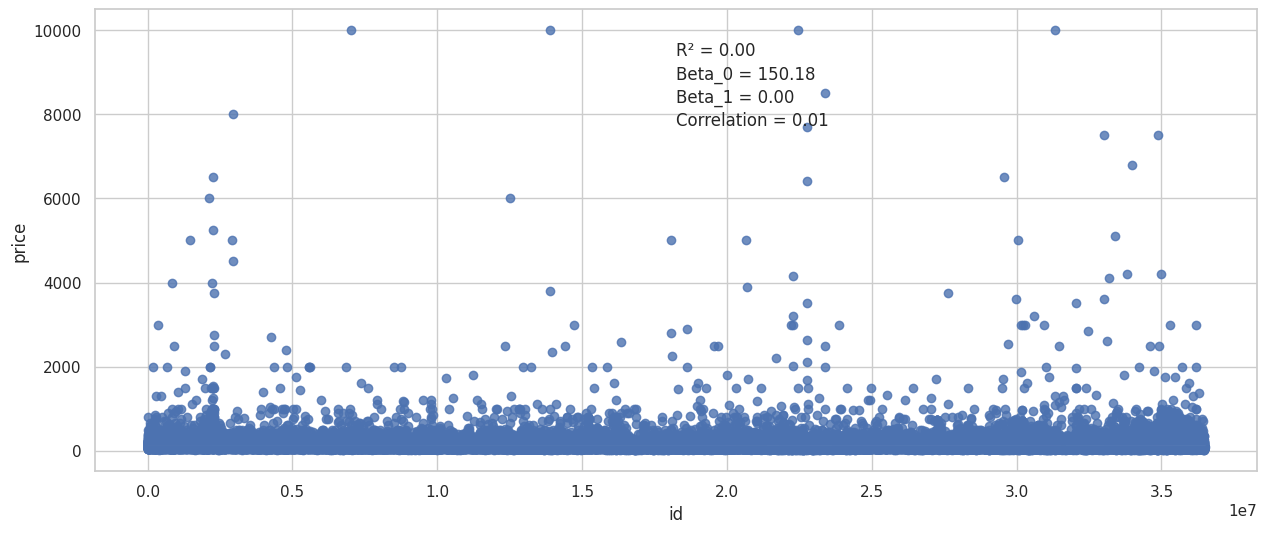

In [52]:
X = sm.add_constant(df4['id'])
y = df4['price']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = df4['id'].corr(df4['price'])

sns.set(style="whitegrid")
ax = sns.regplot(x='id', y='price', data=df4)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='id', ylabel='price')
plt.gcf().set_size_inches(15, 6)
plt.show()

### **nome**

In [53]:
print(len(df4))
print(len(df4['nome'].unique()))

39115
38444


In [54]:
aux=df4[['nome','price']].groupby('nome').mean().sort_values('price',ascending=False).reset_index().head(50)
aux

,nome,price
0,1-BR Lincoln Center,10000.0
1,Furnished room in Astoria apartment,10000.0
2,Luxury 1 bedroom apt. -stunning Manhattan views,10000.0
3,2br - The Heart of NYC: Manhattans Lower East ...,9999.0
4,Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho,8500.0
5,Film Location,8000.0
6,East 72nd Townhouse by (Hidden by Airbnb),7703.0
7,70' Luxury MotorYacht on the Hudson,7500.0
8,Gem of east Flatbush,7500.0
9,3000 sq ft daylight photo studio,6800.0


In [55]:
aux=df4[['nome','price']].groupby('nome').mean().sort_values('price',ascending=True).reset_index().head(50)
aux

,nome,price
0,Couch in Harlem Harvey Refugees only,10.0
1,Jen Apt,10.0
2,Cozy room in a three-bedroom House,10.0
3,Bronx Apart,10.0
4,Voted #1 Airbnb In NYC,10.0
5,"Newly renovated, fully furnished room in Brooklyn",10.0
6,"Girls only, cozy room one block from Times Square",10.0
7,"Quiet, Cozy UES Studio Near the Subway",10.0
8,"Charming, bright and brand new Bed-Stuy home",10.0
9,Spacious 2-bedroom Apt in Heart of Greenpoint,10.0


### **host_name**

In [56]:
print(len(df4))
print(len(df4['host_name'].unique()))

39115
10029


In [57]:
# aux=df4[['host_name','price']].groupby('host_name').mean().sort_values('price',ascending=False).reset_index().head(20)
aux = (df4[['host_name', 'price']].groupby('host_name')
                                  .agg({'price': ['mean', 'count']})
                                  .sort_values(('price', 'mean'), ascending=False)
                                  .reset_index().head(20))
aux

host_name   price      
                       mean count
0               Rum  8500.0     1
1       Jay And Liz  6000.0     1
2          Kathrine  5158.0     2
3           Sarah-2  5000.0     1
4              Nony  4200.0     1
5            Jelena  3400.0     3
6   Luxury Property  3000.0     1
7           Rogelio  2999.0     1
8          Viberlyn  2995.0     1
9   Ilo And Richard  2990.0     1
10            Lanie  2900.0     1
11             Shah  2600.0     1
12             Indi  2400.0     1
13            Iveta  2350.0     1
14              Ege  2000.0     1
15      Mary Rotsen  1999.0     1
16     Ben And Jess  1899.0     1
17            Romeo  1799.0     1
18             Ilsa  1750.0     1
19            NuAve  1750.0     1

In [58]:
aux = (df4[['host_name', 'price']].groupby('host_name')
                                  .agg({'price': ['mean', 'count']})
                                  .sort_values(('price', 'mean'), ascending=True)
                                  .reset_index().head(20))
aux

host_name price      
                          mean count
0      Vishanti & Jeremy  10.0     1
1                  Salim  10.0     1
2               Carolann  12.0     1
3                 Kevin4  18.0     2
4                   Imoy  19.5     2
5              Kartikeya  20.0     1
6           Ben And Jane  20.0     1
7               Elisheva  20.0     1
8            Rimma & Jim  20.0     1
9                Jesus A  22.0     1
10                Satish  22.0     1
11  Christine & Einstein  22.0     1
12                 Zafir  23.0     1
13                   Ysa  24.0     1
14                Kelcie  24.0     1
15            LKL Rental  24.0     3
16                  Lens  25.0     1
17                Luqian  25.0     1
18                Hayden  25.0     1
19             Reggae In  25.0     1

### **bairro_group**

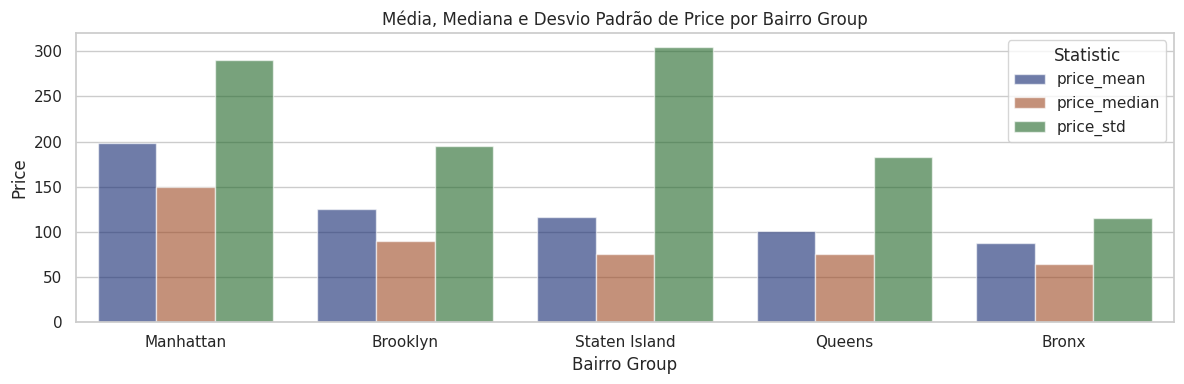

In [59]:
aux1 = df4[['bairro_group', 'price']].groupby('bairro_group').mean().sort_values('price', ascending=False).reset_index()
aux2 = df4[['bairro_group', 'price']].groupby('bairro_group').median().sort_values('price', ascending=False).reset_index()
aux3 = df4[['bairro_group', 'price']].groupby('bairro_group').std().sort_values('price', ascending=False).reset_index()

result1 = pd.merge(aux1, aux2, on='bairro_group', suffixes=('_mean', '_median'))
result2 = pd.merge(result1, aux3, on='bairro_group', suffixes=('', '_std'))
aux = result2.rename(columns={'price': 'price_std'})

viz = pd.melt(aux, id_vars=['bairro_group'], value_vars=['price_mean', 'price_median', 'price_std'],
              var_name='Statistic', value_name='Value')

plt.figure(figsize=(12, 4))
ax = sns.barplot(
    data=viz, x="bairro_group", y="Value", hue="Statistic",
    errorbar="sd", palette="dark", alpha=.6)

ax.set_title('Média, Mediana e Desvio Padrão de Price por Bairro Group')
ax.set_xlabel('Bairro Group')
ax.set_ylabel('Price')

plt.tight_layout()

### **bairro**

In [60]:
print(len(df4))
print(len(df4['bairro'].unique()))

39115
218


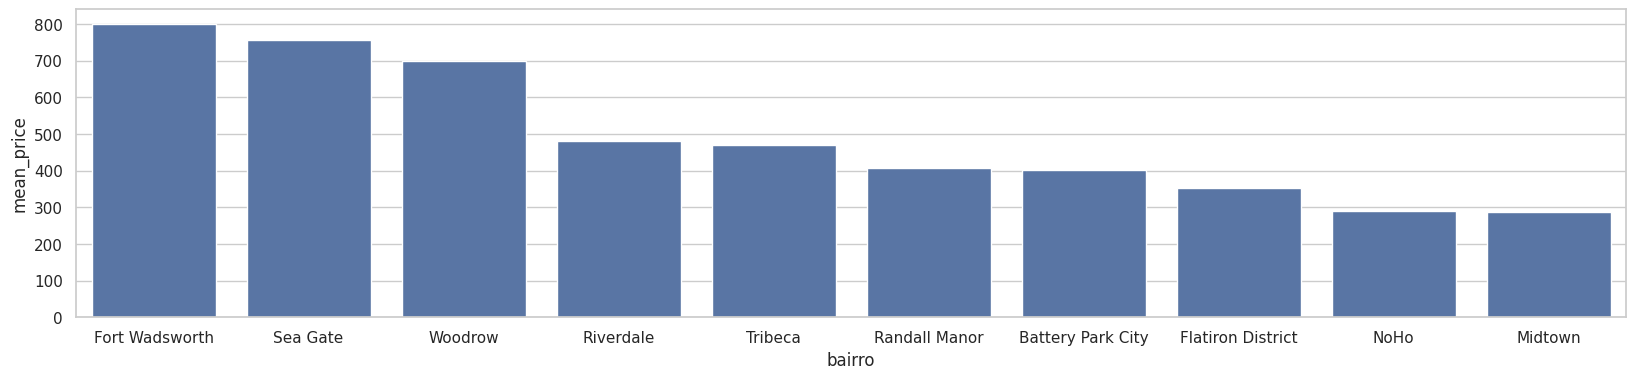

In [61]:
aux1=df4[['bairro','price']].groupby('bairro').mean().sort_values('price',ascending=False).rename(columns={'price':'mean_price'}).reset_index().head(10)
plt.figure(figsize=(20, 4))
sns.barplot(data=aux1,x='bairro',y='mean_price');

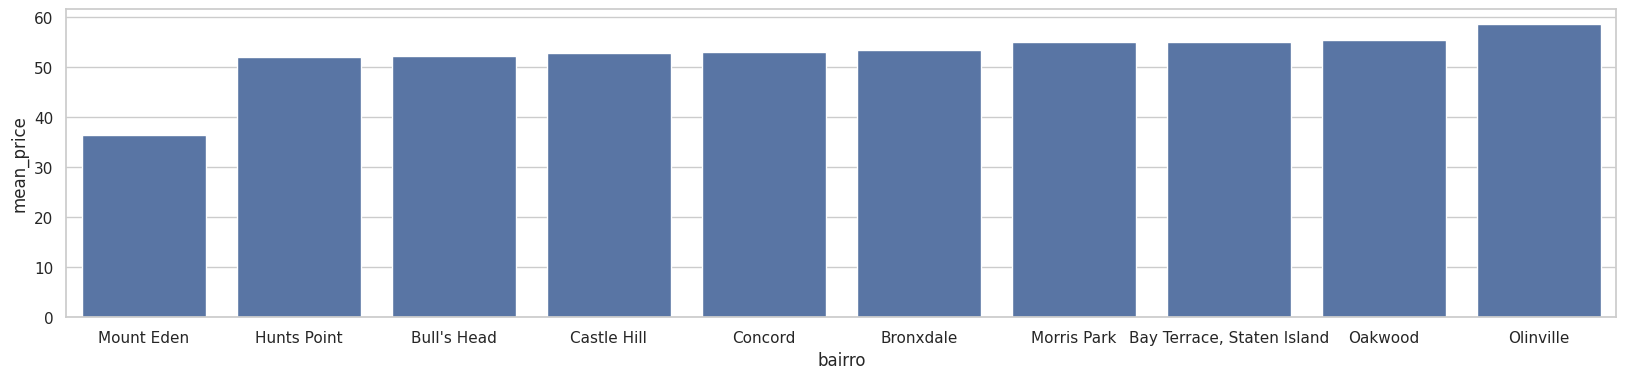

In [62]:
aux1=df4[['bairro','price']].groupby('bairro').mean().sort_values('price',ascending=True).rename(columns={'price':'mean_price'}).reset_index().head(10)
plt.figure(figsize=(20, 4))
sns.barplot(data=aux1,x='bairro',y='mean_price');

### **latitude/longitude**

In [63]:
# lats=df4['latitude']
# lons=df4['longitude']
# locations = list(zip(lats, lons))

# m = folium.Map(location=[np.mean(lats), np.mean(lons)], tiles="Cartodb Positron", zoom_start=1)
# marker_cluster = MarkerCluster(
#     locations=locations,
#     name="1000 clustered icons",
#     overlay=True,
#     control=True)

# marker_cluster.add_to(m)

# folium.LayerControl().add_to(m)

# m

# m.save('../img/map.html')

### **room_type**

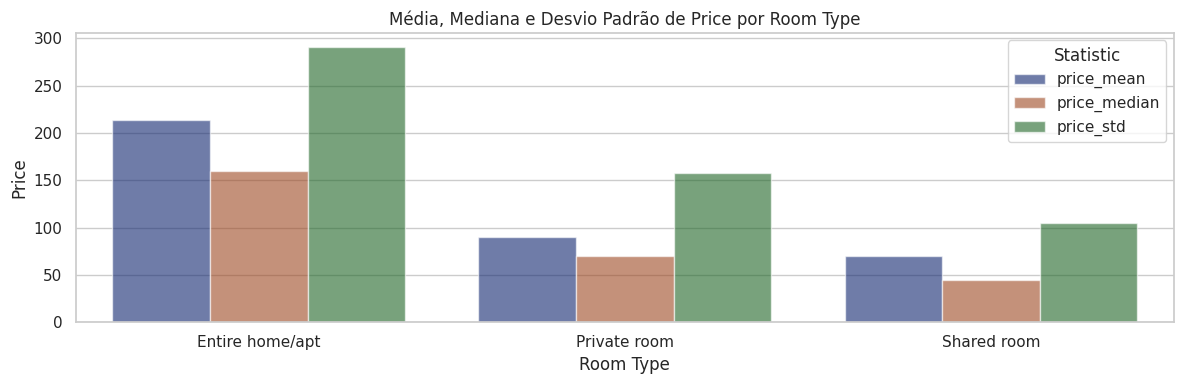

In [64]:
aux1 = df4[['room_type', 'price']].groupby('room_type').mean().sort_values('price', ascending=False).reset_index()
aux2 = df4[['room_type', 'price']].groupby('room_type').median().sort_values('price', ascending=False).reset_index()
aux3 = df4[['room_type', 'price']].groupby('room_type').std().sort_values('price', ascending=False).reset_index()

result1 = pd.merge(aux1, aux2, on='room_type', suffixes=('_mean', '_median'))
result2 = pd.merge(result1, aux3, on='room_type', suffixes=('', '_std'))
aux = result2.rename(columns={'price': 'price_std'})

viz = pd.melt(aux, id_vars=['room_type'], value_vars=['price_mean', 'price_median', 'price_std'],
              var_name='Statistic', value_name='Value')

plt.figure(figsize=(12, 4))
sns.barplot(
    data=viz, x="room_type", y="Value", hue="Statistic",
    errorbar="sd", palette="dark", alpha=.6)

plt.title('Média, Mediana e Desvio Padrão de Price por Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.legend(title='Statistic')

plt.tight_layout()

### **minimo_noites**

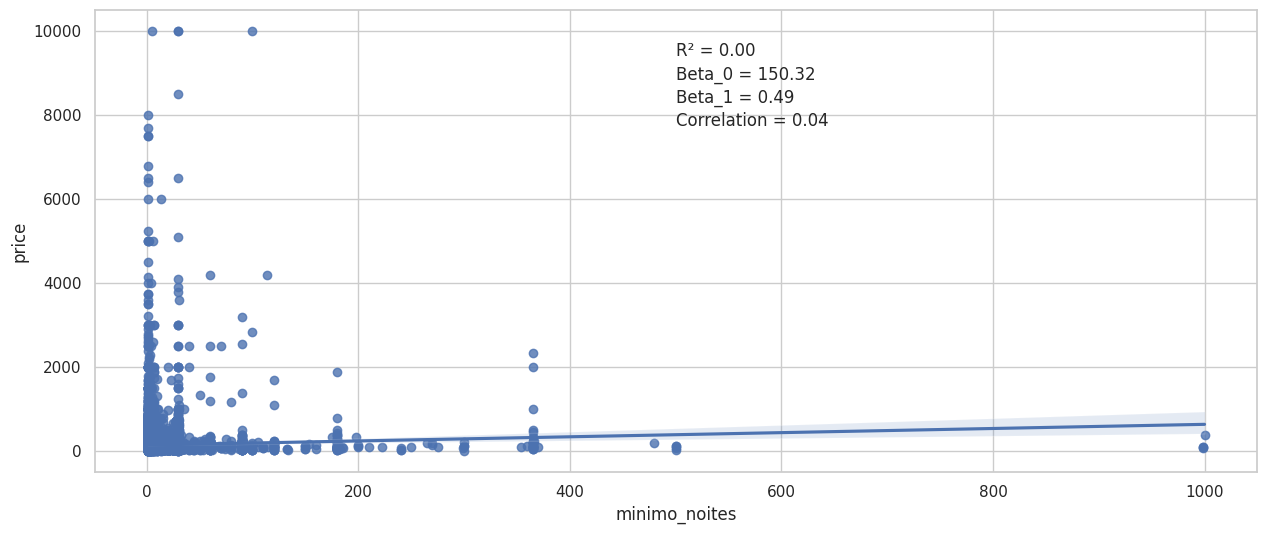

In [65]:
X = sm.add_constant(df4['minimo_noites'])
y = df4['price']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = df4['minimo_noites'].corr(df4['price'])

sns.set(style="whitegrid")
ax = sns.regplot(x='minimo_noites', y='price', data=df4)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='minimo_noites', ylabel='price')
plt.gcf().set_size_inches(15, 6)
plt.show()

### **numero_de_reviews**

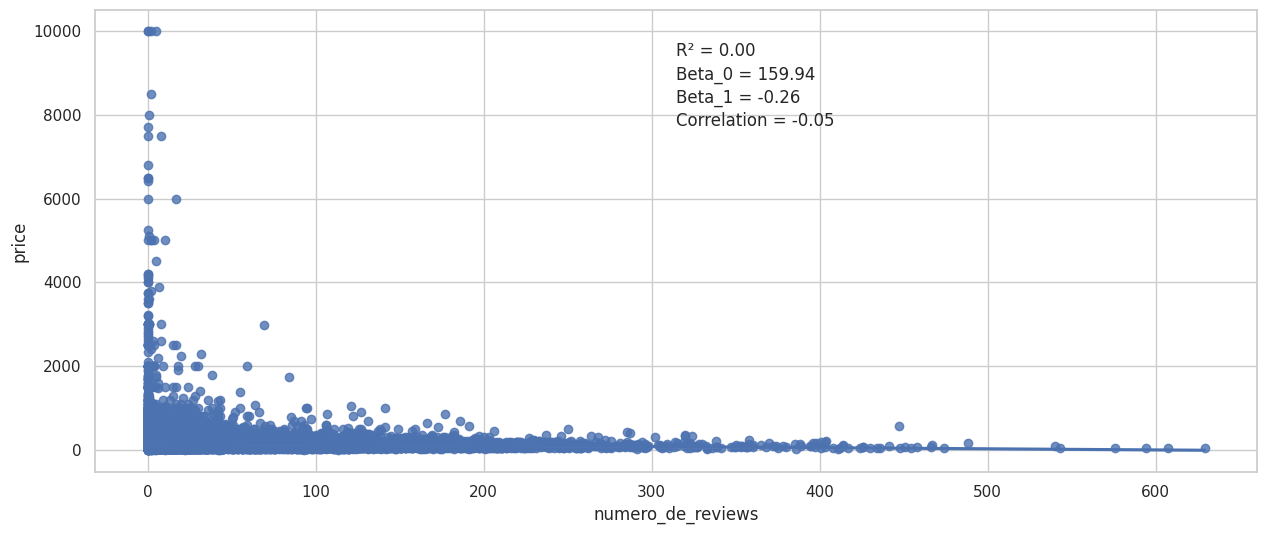

In [66]:
X = sm.add_constant(df4['numero_de_reviews'])
y = df4['price']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = df4['numero_de_reviews'].corr(df4['price'])

sns.set(style="whitegrid")
ax = sns.regplot(x='numero_de_reviews', y='price', data=df4)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='numero_de_reviews', ylabel='price')
plt.gcf().set_size_inches(15, 6)
plt.show()

### **ultima_review**

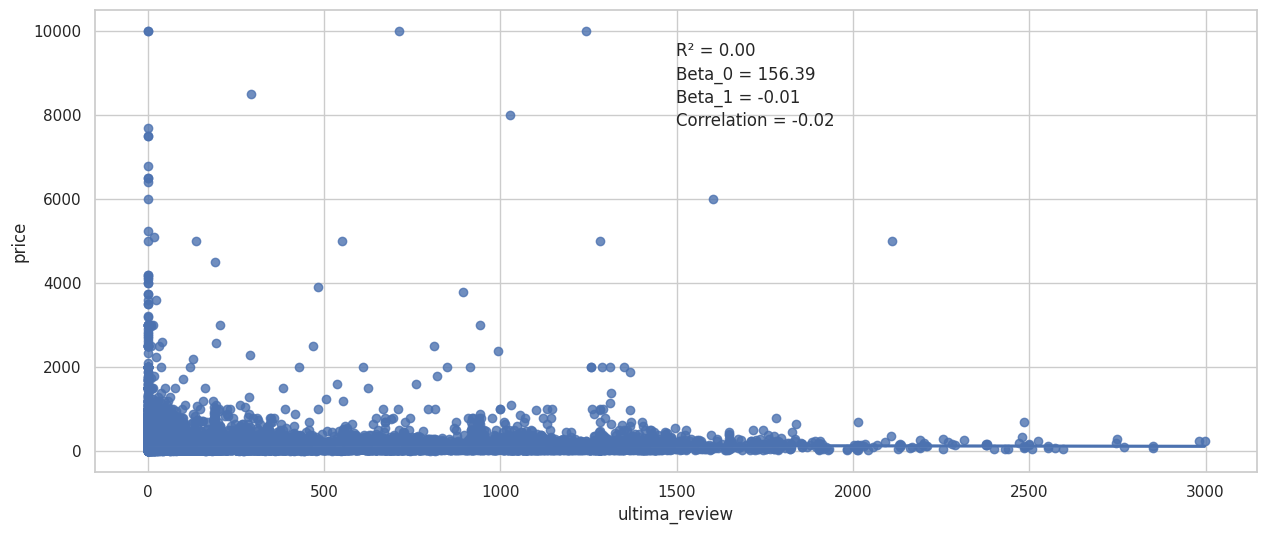

In [67]:
df4['ultima_review'] = df4['ultima_review'].fillna('2019-07-09')

ref_date = pd.to_datetime('2019-07-09')
df4['ultima_review'] = (df4['ultima_review'] - ref_date).dt.days
df4['ultima_review']=df4['ultima_review'] * -1

X = sm.add_constant(df4['ultima_review'])
y = df4['price']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = df4['ultima_review'].corr(df4['price'])

sns.set(style="whitegrid")
ax = sns.regplot(x='ultima_review', y='price', data=df4)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='ultima_review', ylabel='price')
plt.gcf().set_size_inches(15, 6)
plt.show()

### **reviews_por_mes**

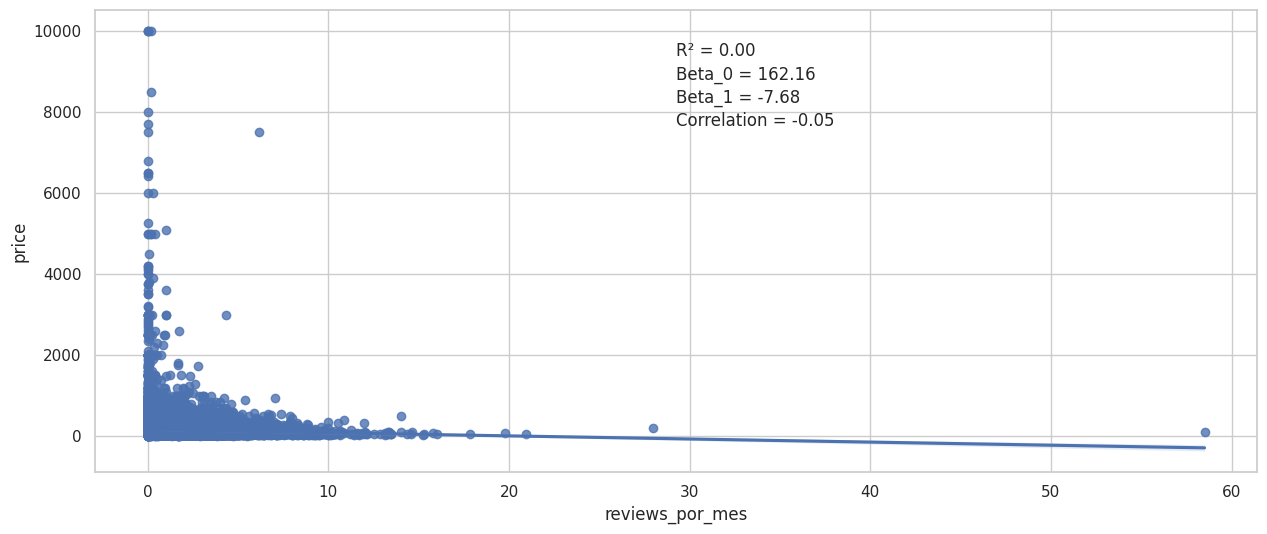

In [66]:
X = sm.add_constant(df4['reviews_por_mes'])
y = df4['price']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = df4['reviews_por_mes'].corr(df4['price'])

sns.set(style="whitegrid")
ax = sns.regplot(x='reviews_por_mes', y='price', data=df4)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='reviews_por_mes', ylabel='price')
plt.gcf().set_size_inches(15, 6)
plt.show()

### **calculado_host_listings_count**

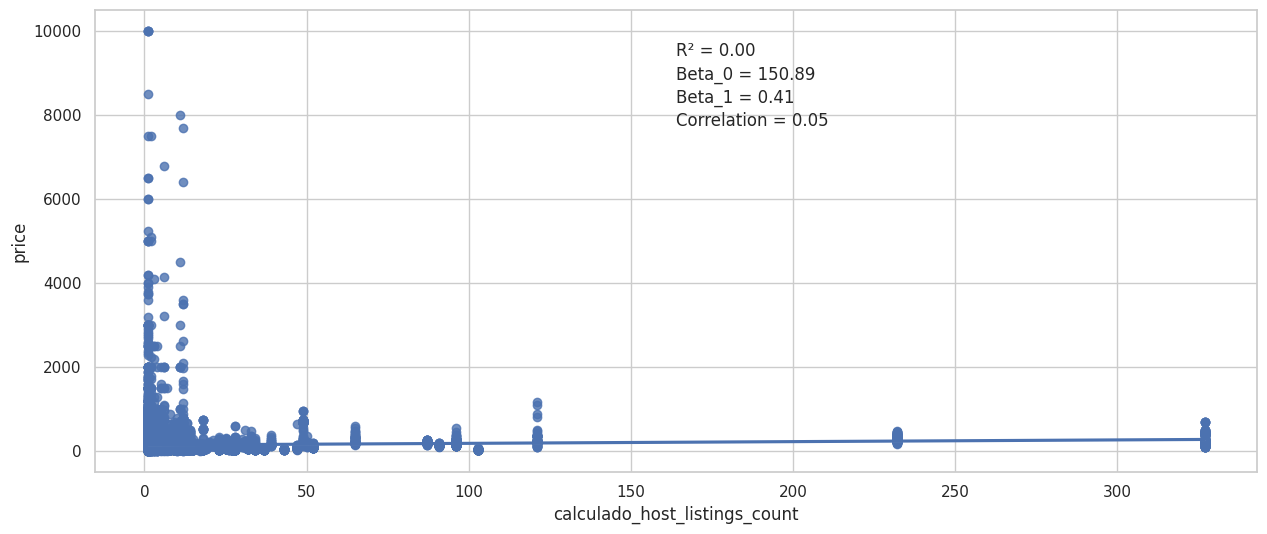

In [111]:
X = sm.add_constant(df4['calculado_host_listings_count'])
y = df4['price']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = df4['calculado_host_listings_count'].corr(df4['price'])

sns.set(style="whitegrid")
ax = sns.regplot(x='calculado_host_listings_count', y='price', data=df4)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='calculado_host_listings_count', ylabel='price')
plt.gcf().set_size_inches(15, 6)
plt.show()

### **disponibilidade_365**

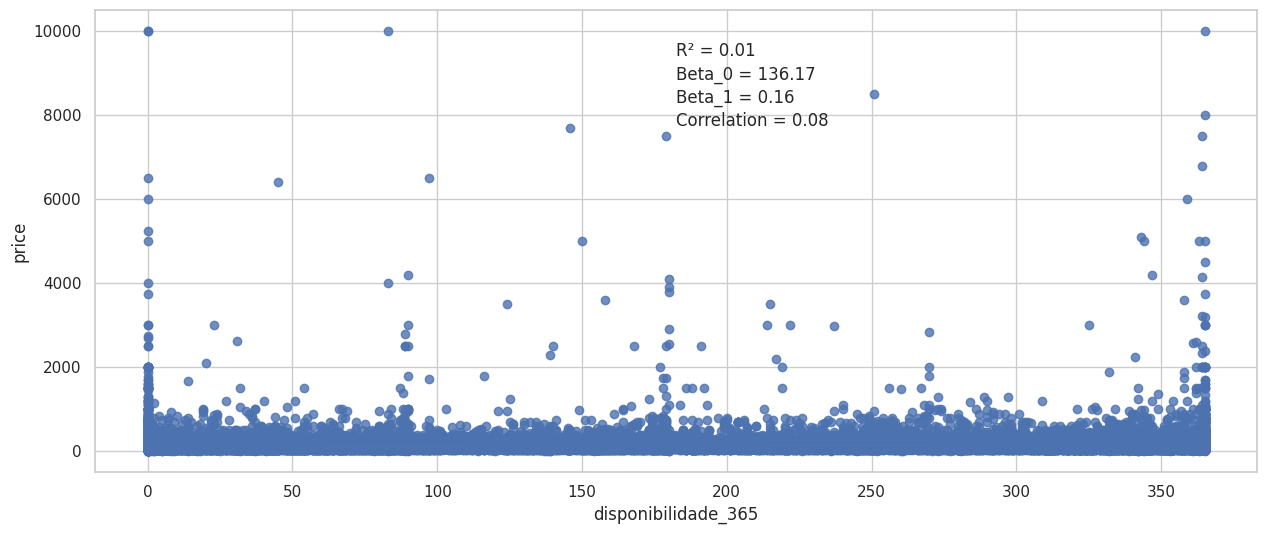

In [110]:
X = sm.add_constant(df4['disponibilidade_365'])
y = df4['price']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = df4['disponibilidade_365'].corr(df4['price'])

sns.set(style="whitegrid")
ax = sns.regplot(x='disponibilidade_365', y='price', data=df4)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='disponibilidade_365', ylabel='price')
plt.gcf().set_size_inches(15, 6)
plt.show()

## **4.4 Multivariate analysis**


### **4.4.1 Numerical attributes**

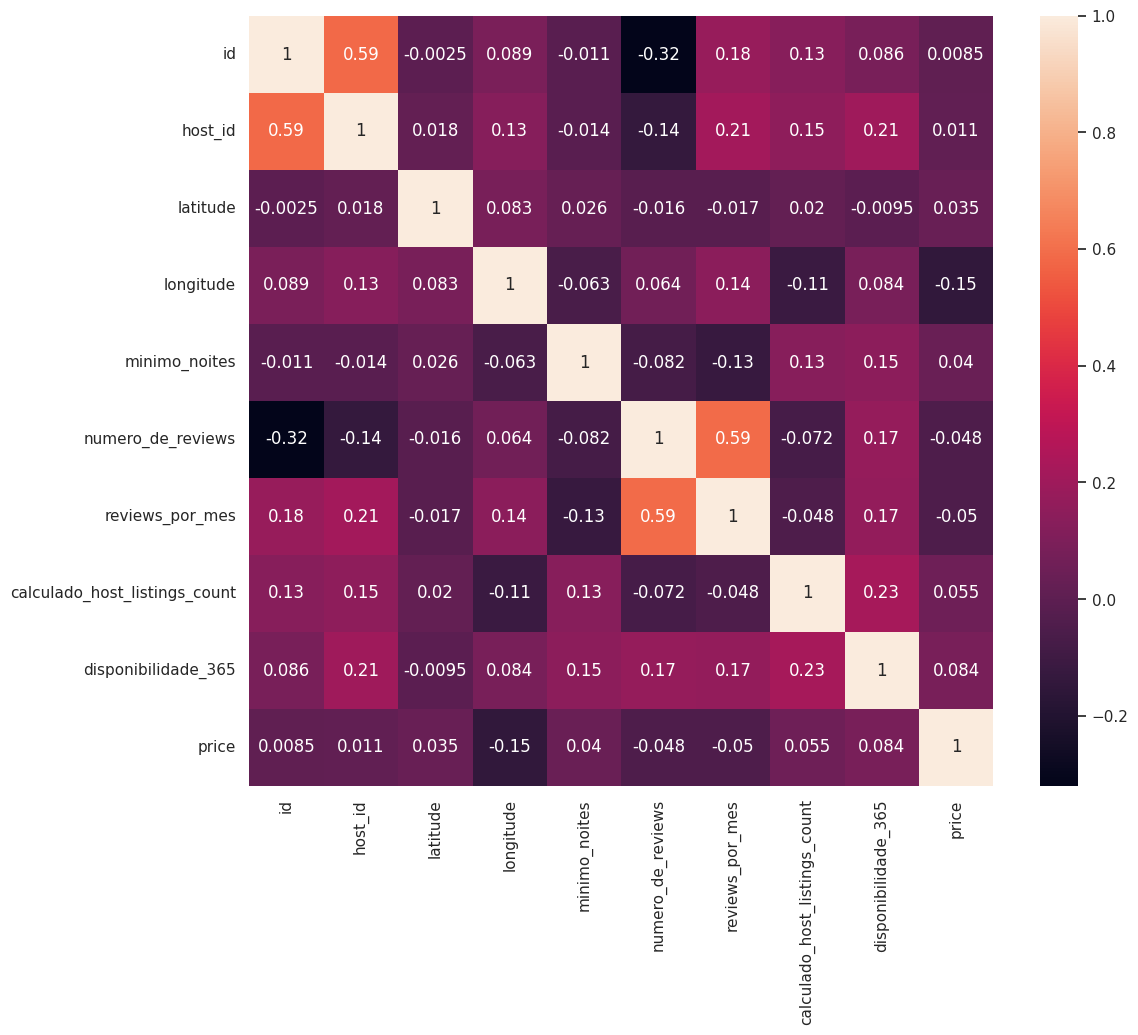

In [69]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

aux=df4[['host_id','id','price','minimo_noites','numero_de_reviews','ultima_review','reviews_por_mes','calculado_host_listings_count','disponibilidade_365']]
correlation=num_attributes.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(correlation,annot=True);
plt.show()

#### numero_de_reviews e id

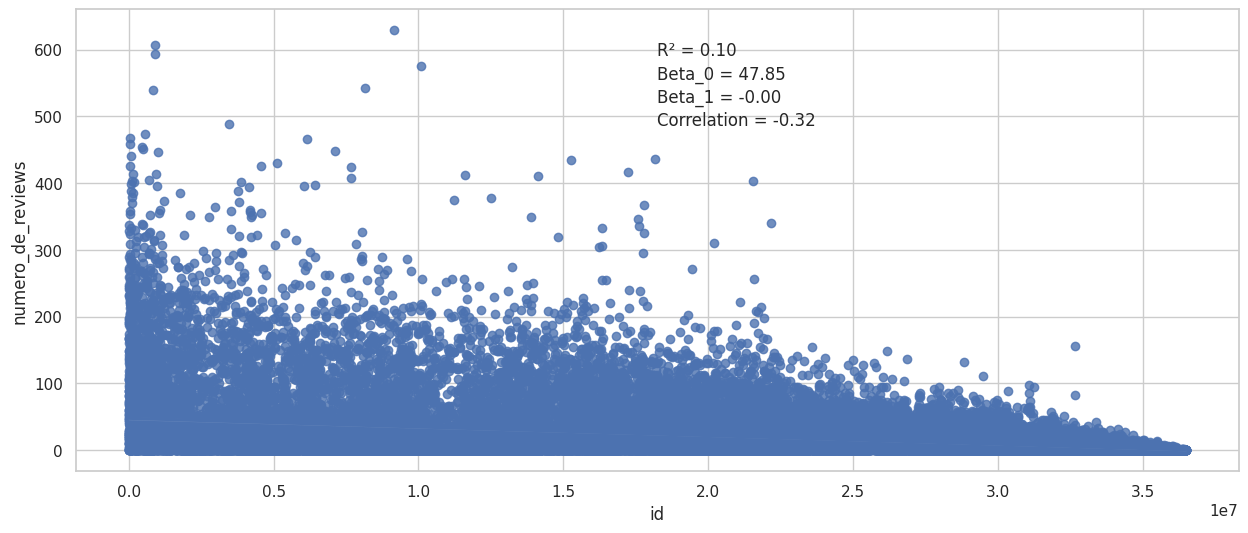

In [70]:
X = sm.add_constant(aux['id'])
y = aux['numero_de_reviews']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = aux['id'].corr(aux['numero_de_reviews'])

sns.set(style="whitegrid")
ax = sns.regplot(x='id', y='numero_de_reviews', data=aux)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='id', ylabel='numero_de_reviews')
plt.gcf().set_size_inches(15, 6)
plt.show()

#### minimo_noites e numero_de_reviews

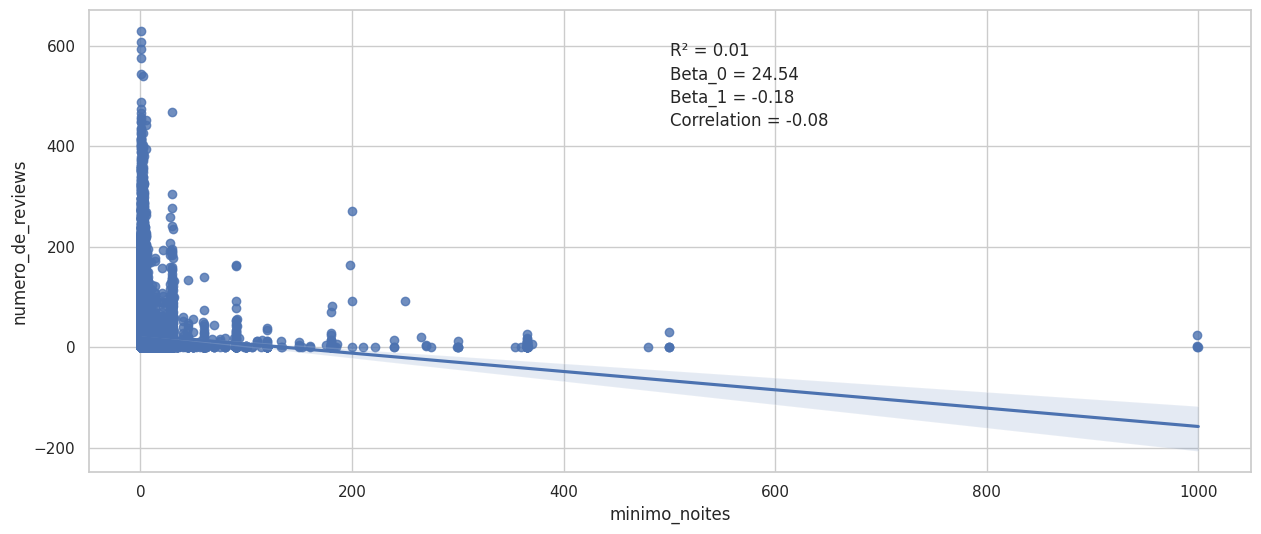

In [71]:
X = sm.add_constant(aux['minimo_noites'])
y = aux['numero_de_reviews']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = aux['minimo_noites'].corr(aux['numero_de_reviews'])

sns.set(style="whitegrid")
ax = sns.regplot(x='minimo_noites', y='numero_de_reviews', data=aux)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='minimo_noites', ylabel='numero_de_reviews')
plt.gcf().set_size_inches(15, 6)
plt.show()

### **4.4.2 Categorical attributes**

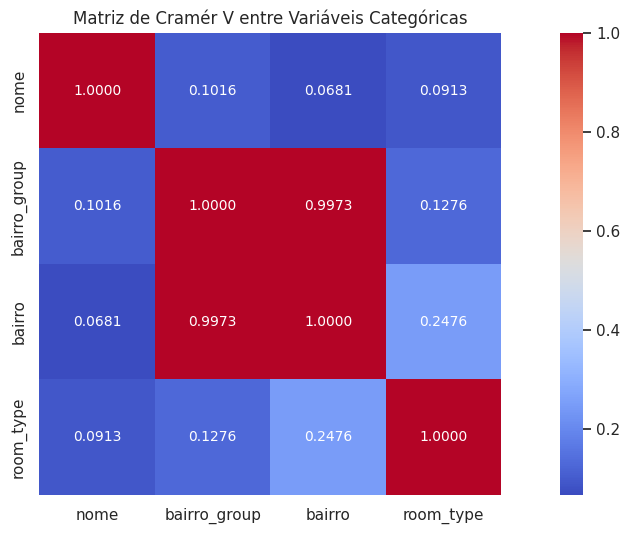

In [72]:
nome = df4['nome']
bairro_group = df4['bairro_group']
bairro = df4['bairro']
room_type = df4['room_type']

# Criar DataFrame para visualização
dataframe_for_heatmap = pd.DataFrame({
    'nome': nome,
    'bairro_group': bairro_group,
    'bairro': bairro,
    'room_type': room_type
})

# Calcular matriz de Cramér V
cramers_v_matrix = calculate_cramers_v_matrix(dataframe_for_heatmap)

# Criar heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.4f', annot_kws={'size': 10})
plt.title('Matriz de Cramér V entre Variáveis Categóricas')
plt.show()

## **4.5 Main insights**

- A variável resposta possui muitos outliers mas tem uma concentração muito alta em valores mais baixos, também possui 9 linhas com valor igual a zero.

- A chave única para cada anúncio e id do usuário provavelmente são geradas aleatoriamente.

- Alguns host names são repetidos trazendo uma média de preço para um nome específico; isso talvez até possibilitasse o uso de um target encoder, porém atrelar nomes de pessoas a valores de aluguel não faz muito sentido.

- Existe uma relação muito clara entre bairro_group e o preço (todos os imóveis estão em Nova York).

- O bairro está atrelado ao bairro_group, portanto é uma variável importante, porém devido a essa forte correlação talvez uma delas será excluída.

- Latitude e longitude podem se tornar importantes com algum tratamento, depois será necessário estudar se será inviabilizada devido a uma possível correlação com bairro_group/bairro.

- Existe uma relação muito clara entre room_type e o preço.

- Minimo_noites, numero_de_reviews, ultima_review, reviews_por_mes, calculado_host_listings_count e disponibilidade_365 não possuem uma correlação importante com o preço.

- Fora as correlações já citadas, não há outras importantes. 

# **5 Data preparation**

In [73]:
df5=df4.copy()

## **5.1 Col drops**

In [74]:
X_train=df5.drop(['id','nome','host_id','host_name','ultima_review','price'],axis=1)
y_train=df5['price']

X_val=x_val.drop(['id','nome','host_id','host_name','ultima_review'],axis=1)
X_test=x_test.drop(['id','nome','host_id','host_name','ultima_review'],axis=1)

print(len(x_train))
print(len(x_val))
print(len(x_test))

39115
4889
4890


## **5.2 Histograms**

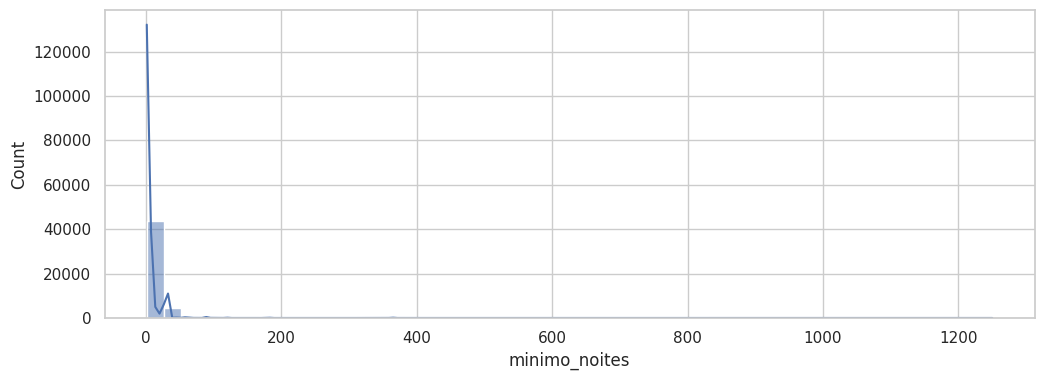

In [75]:
plt.figure(figsize=(12, 4))
sns.histplot(df1, x='minimo_noites',bins=50, kde=True)
plt.show()

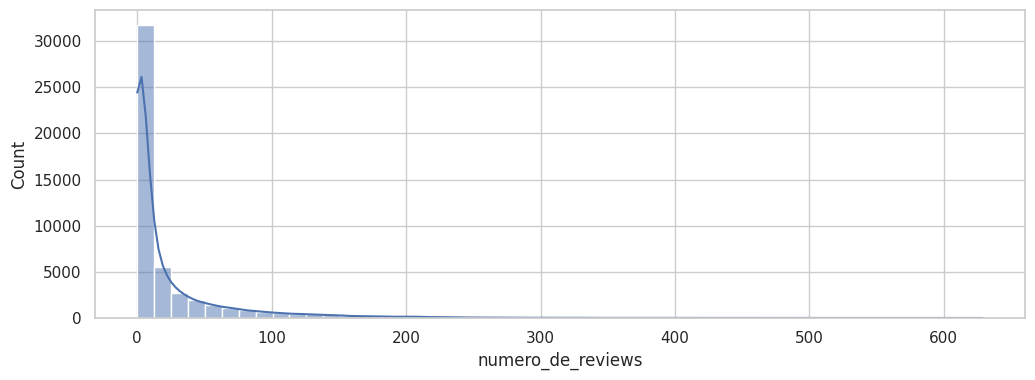

In [76]:
plt.figure(figsize=(12, 4))
sns.histplot(df1, x='numero_de_reviews',bins=50, kde=True)
plt.show()

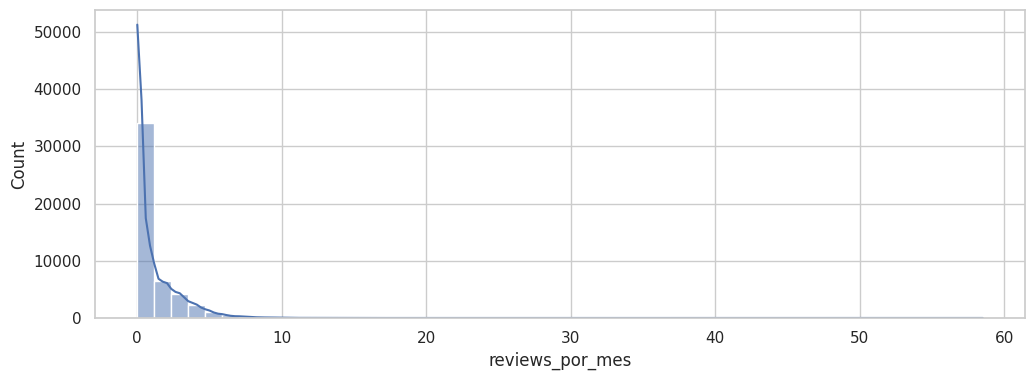

In [77]:
plt.figure(figsize=(12, 4))
sns.histplot(df1, x='reviews_por_mes',bins=50, kde=True)
plt.show()

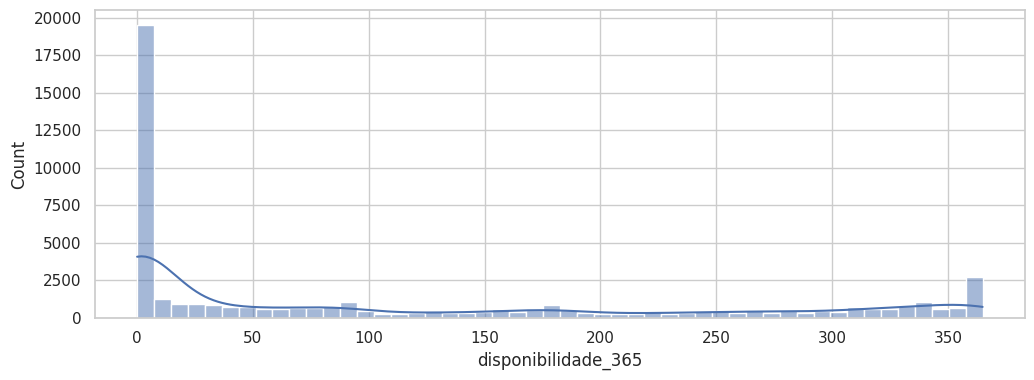

In [78]:
plt.figure(figsize=(12, 4))
sns.histplot(df1, x='disponibilidade_365',bins=50, kde=True)
plt.show()

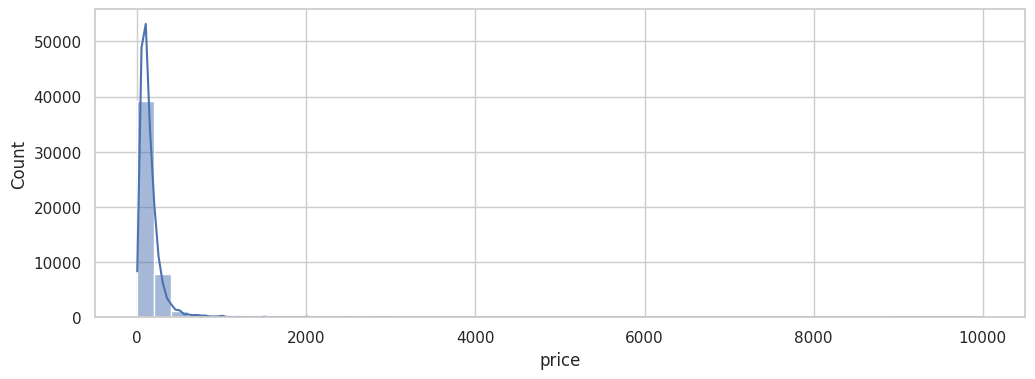

In [79]:
plt.figure(figsize=(12, 4))
sns.histplot(df1, x='price',bins=50, kde=True)
plt.show()

## **5.3 Standardization**

In [80]:
# to_normalize = ['minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365']

# for var in to_normalize:
#     scaler = StandardScaler()
#     X_train[var] = scaler.fit_transform(X_train[[var]].values)
#     X_val[var] = scaler.transform(X_val[[var]].values)
#     X_test[var] = scaler.transform(X_test[[var]].values)
#     scalers[var] = scaler

## **5.4 Rescaling**

In [81]:
# to_normalize = ['minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365']

# scalers = {}


# for var in to_normalize:
#     scaler = MinMaxScaler()
#     X_train[var] = scaler.fit_transform(X_train[[var]].values)
#     X_val[var] = scaler.transform(X_val[[var]].values)
#     X_test[var] = scaler.transform(X_test[[var]].values)
#     scalers[var] = scaler
    
# for var in to_normalize:
#     scaler = RobustScaler()
#     X_train[var] = scaler.fit_transform(X_train[[var]].values)
#     X_val[var] = scaler.transform(X_val[[var]].values)
#     X_test[var] = scaler.transform(X_test[[var]].values)
#     scalers[var] = scaler
    
y_train=np.log1p(y_train) 
y_val=np.log1p(y_val)
y_test=np.log1p(y_test) 

## **5.5 Encoding**

In [82]:
# bairro_groups
X_train=pd.get_dummies(X_train,prefix=['bairro_group'],columns=['bairro_group'])
X_val=pd.get_dummies(X_val,prefix=['bairro_group'],columns=['bairro_group'])
X_test=pd.get_dummies(X_test,prefix=['bairro_group'],columns=['bairro_group'])

# room_type
X_train=pd.get_dummies(X_train,prefix=['room_type'],columns=['room_type'])
X_val=pd.get_dummies(X_val,prefix=['room_type'],columns=['room_type'])
X_test=pd.get_dummies(X_test,prefix=['room_type'],columns=['room_type'])

# bairro
te = TargetEncoder(cols=['bairro'])

X_train = te.fit_transform(X_train, y_train)
X_val = te.transform(X_val)
X_test = te.transform(X_test)

In [83]:
# print(x_train.isna().sum())
# print(x_val.isna().sum())
# print(x_test.isna().sum())

# **6 <s>Feature selection<s/>**

In [84]:
df6=df5.copy()

# **7 Machine Learning**

In [85]:
df7=df6.copy()

## **7.1 Average model**

In [86]:
target = df7['price']

mean_prediction = target.mean()

baseline_predictions = pd.Series([mean_prediction] * len(target))

mae_baseline = mean_absolute_error(target, baseline_predictions)
mape_baseline = mean_absolute_percentage_error(target, baseline_predictions)
mse_baseline = mean_squared_error(target, baseline_predictions)
rmse_baseline = np.sqrt(mse_baseline)

result_baseline = pd.DataFrame({'Model Name': 'Baseline model',
                       'MAE': mae_baseline,
                       'MAPE': mape_baseline,
                       'RMSE': rmse_baseline}, index=[0])
result_baseline

,Model Name,MAE,MAPE,RMSE
0,Baseline model,93.866499,0.904171,244.144942


## **7.2 Linear regression**

In [87]:
# model
lr=LinearRegression().fit(X_train,y_train)

# prediction
lr_yhat=lr.predict(X_val)

mae_lr = mean_absolute_error(np.expm1(y_val), np.expm1(lr_yhat))
mape_lr = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(lr_yhat))
mse_lr = mean_squared_error(np.expm1(y_val), np.expm1(lr_yhat))
rmse_lr = np.sqrt((mse_lr))

result_lr = pd.DataFrame({'Model Name': 'Linear Regression',
                       'MAE': mae_lr,
                       'MAPE': mape_lr,
                       'RMSE': rmse_lr}, index=[0])
result_lr

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,57.281414,0.3408,248.011434


### **7.2.1 Linear regression model - Cross validation** 

In [88]:
lr_cv = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(lr_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_lr_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_lr_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_lr_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_lr_cv)
std_mape = np.std(-mape_lr_cv)
std_rmse = np.std(-rmse_lr_cv)

result_lr_cv = pd.DataFrame({'Model Name': 'Linear Regression CV',
                              'MAE': mae_lr_cv,
                              'MAPE': mape_lr_cv,
                              'RMSE': rmse_lr_cv}, index=[0])

result_lr_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression CV,62.263106,0.351555,231.859035


## **7.3 Linear regression regularized**

In [89]:
# model
lrr=Lasso().fit(X_train,y_train)
 
# prediction
lrr_yhat=lrr.predict(X_val)

mae_lrr = mean_absolute_error(np.expm1(y_val), np.expm1(lrr_yhat))
mape_lrr = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(lrr_yhat))
mse_lrr = mean_squared_error(np.expm1(y_val), np.expm1(lrr_yhat))
rmse_lrr = np.sqrt(mse_lrr)

result_lrr = pd.DataFrame({'Model Name': 'Lasso',
                       'MAE': mae_lrr,
                       'MAPE': mape_lrr,
                       'RMSE': rmse_lrr}, index=[0])
result_lrr

,Model Name,MAE,MAPE,RMSE
0,Lasso,78.611361,0.588192,259.527079


### **7.3.1 Linear regression regularized - Cross Validation**

In [90]:
lrr_cv = Lasso()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(lrr_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_lrr_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_lrr_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_lrr_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_lrr_cv)
std_mape = np.std(-mape_lrr_cv)
std_rmse = np.std(-rmse_lrr_cv)

result_lrr_cv = pd.DataFrame({'Model Name': 'Linear Regression CV',
                              'MAE': mae_lrr_cv,
                              'MAPE': mape_lrr_cv,
                              'RMSE': rmse_lrr_cv}, index=[0])

result_lrr_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression CV,84.219075,0.608652,246.659921


## **7.4 Random Forest Regressor**

In [91]:
# model
rf=RandomForestRegressor(n_jobs=-1,random_state=95).fit(X_train,y_train)

# prediction
rf_yhat=rf.predict(X_val)

mae_rf = mean_absolute_error(np.expm1(y_val), np.expm1(rf_yhat))
mape_rf = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(rf_yhat))
mse_rf = mean_squared_error(np.expm1(y_val), np.expm1(rf_yhat))
rmse_rf = np.sqrt(mse_rf)

result_rf = pd.DataFrame({'Model Name': 'Random Forest',
                       'MAE': mae_rf,
                       'MAPE': mape_rf,
                       'RMSE': rmse_rf}, index=[0])
result_rf

,Model Name,MAE,MAPE,RMSE
0,Random Forest,53.904047,0.322832,243.864517


### **7.4.1 Random forest regressor - Cross validation** 

In [92]:
rf_cv=RandomForestRegressor(n_jobs=-1,random_state=95)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(rf_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_rf_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_rf_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_rf_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_rf_cv)
std_mape = np.std(-mape_rf_cv)
std_rmse = np.std(-rmse_rf_cv)

result_rf_cv = pd.DataFrame({'Model Name': 'Random Forest CV',
                              'MAE': mae_rf_cv,
                              'MAPE': mape_rf_cv,
                              'RMSE': rmse_rf_cv}, index=[0])

result_rf_cv

,Model Name,MAE,MAPE,RMSE
0,Random Forest CV,57.824397,0.330461,218.624264


## **7.5 XGBoost regressor**

In [93]:
xgb_model=XGBRegressor(n_jobs=-1,random_state=95).fit(X_train,y_train)

# prediction
xgb_yhat=xgb_model.predict(X_val)

mae_xgb = mean_absolute_error(np.expm1(y_val), np.expm1(xgb_yhat))
mape_xgb = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(xgb_yhat))
mse_xgb = mean_squared_error(np.expm1(y_val), np.expm1(xgb_yhat))
rmse_xgb = np.sqrt(mse_xgb)

result_xgb = pd.DataFrame({'Model Name': 'XGBoost',
                       'MAE': mae_xgb,
                       'MAPE': mape_xgb,
                       'RMSE': rmse_xgb}, index=[0])
result_xgb

,Model Name,MAE,MAPE,RMSE
0,XGBoost,53.187292,0.313725,244.412763


### **7.6 XGBoost regressor - Cross validation**

In [94]:
xgb_model_cv=XGBRegressor(n_jobs=-1,random_state=95)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(xgb_model_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_xgb_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_xgb_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_xgb_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_xgb_cv)
std_mape = np.std(-mape_xgb_cv)
std_rmse = np.std(-rmse_xgb_cv)

result_xgb_cv = pd.DataFrame({'Model Name': 'XGBoost CV',
                              'MAE': mae_xgb_cv,
                              'MAPE': mape_xgb_cv,
                              'RMSE': rmse_xgb_cv}, index=[0])

result_xgb_cv

,Model Name,MAE,MAPE,RMSE
0,XGBoost CV,57.629471,0.326462,219.326778


## **7.6 CatBoost regressor**

In [95]:
cat=CatBoostRegressor(logging_level='Silent').fit(X_train,y_train)

# prediction
cat_yhat=cat.predict(X_val)

mae_cat = mean_absolute_error(np.expm1(y_val), np.expm1(cat_yhat))
mape_cat = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(cat_yhat))
mse_cat = mean_squared_error(np.expm1(y_val), np.expm1(cat_yhat))
rmse_cat = np.sqrt(mse_cat)

result_cat = pd.DataFrame({'Model Name': 'CatBoost',
                       'MAE': mae_cat,
                       'MAPE': mape_cat,
                       'RMSE': rmse_cat}, index=[0])
result_cat

,Model Name,MAE,MAPE,RMSE
0,CatBoost,52.218592,0.304304,243.822323


### **7.6.1 CatBoost regressor - Cross validation**

In [96]:
cat_cv=CatBoostRegressor(logging_level='Silent')

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(cat_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_cat_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_cat_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_cat_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_cat_cv)
std_mape = np.std(-mape_cat_cv)
std_rmse = np.std(-rmse_cat_cv)

result_cat_cv = pd.DataFrame({'Model Name': 'CatBoost CV',
                              'MAE': mae_cat_cv,
                              'MAPE': mape_cat_cv,
                              'RMSE': rmse_cat_cv}, index=[0])

result_cat_cv

# sem scaling
# CatBoost CV	56.844326	0.317873	220.550018

# com standard
# CatBoost CV	56.844326	0.317873	220.550018

# com minmax
# CatBoost CV	56.844326	0.317873	220.550018

# com robust
# CatBoost CV	56.844326	0.317873	220.550018

,Model Name,MAE,MAPE,RMSE
0,CatBoost CV,56.819354,0.318346,220.45662


## **7.7 Compare performances**

In [97]:
modelling_result=pd.concat([result_baseline,result_lr,result_lrr,result_rf,result_xgb,result_cat])
modelling_result_cv=pd.concat([result_baseline,result_lr_cv,result_lrr_cv,result_rf_cv,result_xgb_cv,result_cat_cv])

modelling_result.sort_values('MAE',ascending=True)

,Model Name,MAE,MAPE,RMSE
0,CatBoost,52.218592,0.304304,243.822323
0,XGBoost,53.187292,0.313725,244.412763
0,Random Forest,53.904047,0.322832,243.864517
0,Linear Regression,57.281414,0.340800,248.011434
0,Lasso,78.611361,0.588192,259.527079
0,Baseline model,93.866499,0.904171,244.144942


## **7.8 Compare cross-validated performances**

In [98]:
modelling_result_cv.sort_values('MAE',ascending=True)

,Model Name,MAE,MAPE,RMSE
0,CatBoost CV,56.819354,0.318346,220.456620
0,XGBoost CV,57.629471,0.326462,219.326778
0,Random Forest CV,57.824397,0.330461,218.624264
0,Linear Regression CV,62.263106,0.351555,231.859035
0,Linear Regression CV,84.219075,0.608652,246.659921
0,Baseline model,93.866499,0.904171,244.144942


## **7.9 Final model**

In [99]:
full_x = pd.concat ([X_train, X_val], axis=0,ignore_index=True) 
full_y = pd.concat ([y_train, y_val], axis=0,ignore_index=True) 

cat=CatBoostRegressor(logging_level='Silent').fit(full_x,full_y)

# prediction
cat_yhat=cat.predict(X_test)

mae_cat = mean_absolute_error(np.expm1(y_test), np.expm1(cat_yhat))
mape_cat = mean_absolute_percentage_error_func(np.expm1(y_test), np.expm1(cat_yhat))
mse_cat = mean_squared_error(np.expm1(y_test), np.expm1(cat_yhat))
rmse_cat = np.sqrt(mse_cat)

final_result_cat = pd.DataFrame({'Model Name': 'CatBoost',
                       'MAE': mae_cat,
                       'MAPE': mape_cat,
                       'RMSE': rmse_cat}, index=[0])
final_result_cat

,Model Name,MAE,MAPE,RMSE
0,CatBoost,51.903462,0.307537,159.504019


# <s>**8 Hyperparameter fine-tuning**<s/>

# **9 Error translation and interpretation**

In [100]:
df9=x_test.copy()
df9['price']=np.expm1(y_test)
df9['predictions']=np.expm1(cat_yhat)

## **9.1 Business performance**

In [101]:
# sum of predictions
df91=df9[['id','predictions','price']].groupby('id').sum().reset_index()             

# MAE and MAPE
df9_aux1=(df9[['id','price','predictions']].groupby('id')
          .apply(lambda x: mean_absolute_error (x['price'],x['predictions']))
          .reset_index().rename(columns={0:'MAE'}))

df9_aux2=(df9[['id','price','predictions']].groupby('id')
          .apply(lambda x: mean_absolute_percentage_error (x['price'],x['predictions']))
          .reset_index().rename(columns={0:'MAPE'}))

# merge
df9_aux3=pd.merge(df9_aux1,df9_aux2,how='inner',on='id')
df92=pd.merge(df91,df9_aux3,how='inner',on='id')

# scenarios
df92['worst_scenario']=df92['predictions'] - df92['MAE']
df92['best_scenario']=df92['predictions'] + df92['MAE']

# order columns
df92=df92[['id','price','predictions','worst_scenario','best_scenario','MAE','MAPE']]

df92['price']=df92['price'].map('${:,.2f}'.format)
df92['predictions']=df92['predictions'].map('${:,.2f}'.format)
df92['worst_scenario']=df92['worst_scenario'].map('${:,.2f}'.format)
df92['best_scenario']=df92['best_scenario'].map('${:,.2f}'.format)

In [102]:
# top 10 predictions
df92.sort_values('MAPE',ascending=True).head(10).reset_index(drop=True)

,id,price,predictions,worst_scenario,best_scenario,MAE,MAPE
0,30941454,$113.00,$112.99,$112.99,$113.00,0.006889,0.000061
1,4217758,$98.00,$97.99,$97.98,$98.00,0.008165,0.000083
2,25807578,$100.00,$100.01,$100.00,$100.02,0.009176,0.000092
3,18059239,$142.00,$142.02,$142.00,$142.04,0.019000,0.000134
4,7062987,$140.00,$139.97,$139.95,$140.00,0.025109,0.000179
5,1479283,$96.00,$95.97,$95.94,$96.00,0.031851,0.000332
6,16414538,$120.00,$120.04,$120.00,$120.08,0.042380,0.000353
7,13674338,$133.00,$133.05,$133.00,$133.10,0.047552,0.000358
8,1586454,$48.00,$47.98,$47.96,$48.00,0.021327,0.000444
9,20743194,$90.00,$90.06,$90.00,$90.12,0.059402,0.000660


In [103]:
# top 10 worse predictions
df92.sort_values('MAPE',ascending=False).head(10).reset_index(drop=True)

,id,price,predictions,worst_scenario,best_scenario,MAE,MAPE
0,21304320,$0.00,$29.56,$0.00,$59.12,29.561111,1.331314e+17
1,25839759,$10.00,$117.86,$10.00,$225.72,107.858398,1.078584e+01
2,21981703,$12.00,$123.56,$12.00,$235.11,111.555522,9.296294e+00
3,36280646,$16.00,$113.30,$16.00,$210.61,97.304146,6.081509e+00
4,35612982,$12.00,$69.57,$12.00,$127.13,57.567410,4.797284e+00
5,35965985,$44.00,$252.43,$44.00,$460.85,208.425591,4.736945e+00
6,35642891,$10.00,$55.24,$10.00,$100.49,45.244550,4.524455e+00
7,22229244,$20.00,$87.36,$20.00,$154.72,67.360051,3.368003e+00
8,25669472,$25.00,$100.88,$25.00,$176.77,75.884814,3.035393e+00
9,31671972,$45.00,$173.32,$45.00,$301.63,128.316772,2.851484e+00


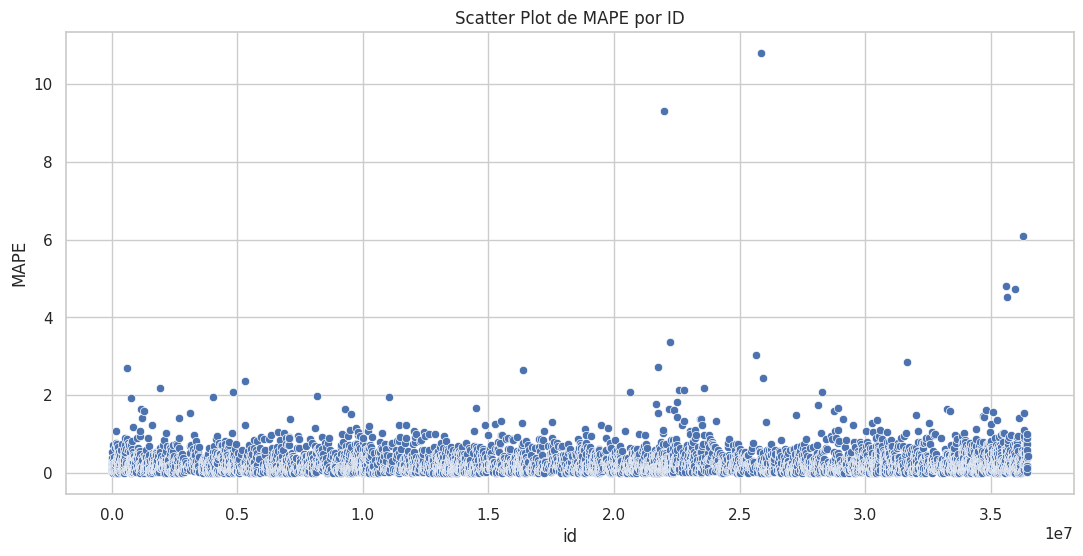

In [104]:
aux=df92.drop(df92[df92['id'] == 21304320].index, axis=0)

# px.scatter(aux,x='id',y='MAPE',height=500)

plt.figure(figsize=(13, 6))  
sns.scatterplot(x='id', y='MAPE', data=aux)
plt.title('Scatter Plot de MAPE por ID')
plt.show()

## **9.2 Total performance**

In [105]:
df92[['price','predictions','worst_scenario','best_scenario']] = (df92[['price','predictions','worst_scenario','best_scenario']]
                                                                    .replace('[\$,]', '', regex=True).astype(float))

aux1=df92[df92['price']<=100]
aux2=df92[(df92['price']>100) & (df92['price']<=300)]
aux3=df92[(df92['price']>300) & (df92['price']<=500)]
aux4=df92[df92['price']>=500]

print(f'MAE médio de aluguéis até $100 : {round(aux1["MAE"].mean(),2)}')
print(f'MAE médio de aluguéis entre $101 a $300 : {round(aux2["MAE"].mean(),2)}')
print(f'MAE médio de aluguéis entre $301 a $500 : {round(aux3["MAE"].mean(),2)}')
print(f'MAE médio de aluguéis acima de $500 : {round(aux4["MAE"].mean(),2)}')

MAE médio de aluguéis até $100 : 20.48
MAE médio de aluguéis entre $101 a $300 : 43.94
MAE médio de aluguéis entre $301 a $500 : 166.05
MAE médio de aluguéis acima de $500 : 646.99


In [106]:
df93=(df92[['price','predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum (x),axis=0)
                                                                    .reset_index()
                                                                    .rename(columns={'index':'Scenario',0:'Values'}))
df93['Values']=df93['Values'].map('${:,.2f}'.format)
df93

,Scenario,Values
0,price,"$725,918.00"
1,predictions,"$631,655.23"
2,worst_scenario,"$377,847.33"
3,best_scenario,"$885,463.35"


## **9.3 Machine learning performance**

In [107]:
df9['error']=df9['price']-df9['predictions']

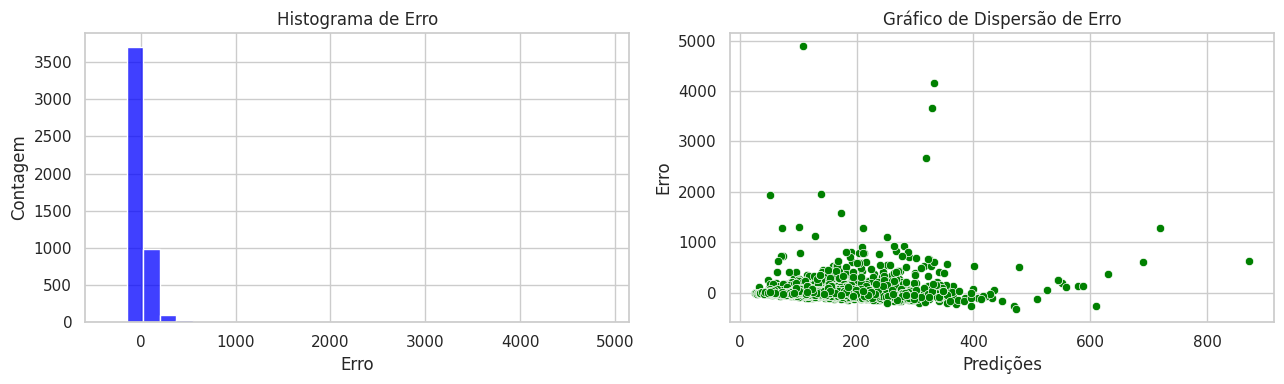

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

sns.histplot(df9['error'], bins=30, color='blue', ax=axs[0])
axs[0].set_title('Histograma de Erro')
axs[0].set_xlabel('Erro')
axs[0].set_ylabel('Contagem')

sns.scatterplot(x='predictions', y='error', data=df9, color='green', ax=axs[1])
axs[1].set_title('Gráfico de Dispersão de Erro')
axs[1].set_xlabel('Predições')
axs[1].set_ylabel('Erro')

plt.tight_layout()
plt.show()

# **10 Entregas**

**Entregas completas ver notebook look_4.0-ear-hp_tuning-error_analysis.ipynb**

### a) Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, 
### onde seria mais indicada a compra?

Pensando na compra de um apartamento, seria no bairro_group Bronx, porque, segundo pesquisas, é o local mais acessível de Nova York    
para se comprar um apartamento, e tentando maximizar o lucro, um apartamento cujo preço de aluguel está acima do 2° quartil (maior que 50% dos preços).  

É necessário também escolher um apartamento cujo número de reviews esteja acima da média, o que sinaliza um local facilmente alugado.

Para aumentar a acurácia desse recomendação, seria necessário analisar os valores de compra dos apartamentos.

In [109]:
# somente no Bronx e número de reviews superior à média geral
aux=df4[(df4['bairro_group']=='Bronx') & (df4['price']>106) & (df4['numero_de_reviews']>23)]

# filtrando apenas apartamentos
keywords = ['Apartment', 'apartment', 'Apt', 'apt']
filter = aux['nome'].str.contains('|'.join(keywords), case=False)
aux = aux[filter]

aux1=aux[['nome','bairro','room_type','price','numero_de_reviews']]
aux1.sort_values('price',ascending=False).head(10).reset_index(drop=True)

,nome,bairro,room_type,price,numero_de_reviews
0,Cozy Sun Drenched Full Apt. 30 mins from City,East Morrisania,Entire home/apt,200,26
1,"Sunny, enormous apt, historic bldg",Melrose,Entire home/apt,150,58
2,1st Floor Cozy 1Br Apt. Near YANKEE STADIUM,Morrisania,Entire home/apt,150,26
3,Cozy Bronx Apt,Tremont,Entire home/apt,150,43
4,It is a two bedroom apartment,Concourse,Entire home/apt,150,84
5,Well located apartment near NY City,Riverdale,Entire home/apt,150,79
6,Large Private House Apartment Near Yankee Stadium,Concourse Village,Entire home/apt,140,106
7,HUGE Sundrenching Apartment Waiting Just For YOU!,Parkchester,Entire home/apt,139,30
8,Private Apt 2BR/1Bath/Kitchen/Parking in OUR HOME,Mott Haven,Entire home/apt,132,44
9,Modern 3BR Brownstone Apartment,Mount Hope,Entire home/apt,125,41


### b) O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

Segundo os resultados já mencionados na EDA, não parece haver uma relação considerável entre o mínimo de noites e a disponibilidade com o preço

### c) Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Sim, existem algumas palavras que se repetem quando se filtra os imóveis com os maiores aluguéis.

Luxury - 5 vezes   
Beautiful - 4 vezes  
SuperBowl - 3 vezes   
Private - 3 vezes   
Townhouse - 3 vezes  
Film - 3 vezes 

**As palavras foram contadas com a ajuda de uma IA com base numa lista dos 50 imóveis com os maiores preços**   
(essas palavras não foram encontradas na lista dos 50 imóveis mais baratos, conforme análise da variável na Bivariate analysis)